# Image Segmentation

In [1]:
%%capture
%pip install opencv-python matplotlib
%pip install 'git+https://github.com/facebookresearch/segment-anything.git'
%pip install -q roboflow supervision

%wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [2]:
%pip install torch


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: pip3.11 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install torchvision
%pip install tensorflow


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: pip3.11 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: pip3.11 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [111]:
import sys
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
# import supervision as sv
import cv2
import matplotlib.pyplot as plt
import torch
import numpy as np
# import tensorflow as tf
import PIL
from PIL import Image
import math
import os

In [2]:
assert torch.cuda.is_available(), "No GPU available"

print("GPU found")
device=torch.device("cuda")

GPU found


In [3]:
MODEL_TYPE = 'vit_h'
sam = sam_model_registry[MODEL_TYPE](checkpoint='sam_vit_h_4b8939.pth')
sam.to(device=device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [4]:
def load_image(image_path):
    max_dim = 512
    img = Image.open(image_path).convert('RGB')
    
    # Resize image while keeping aspect ratio
    width, height = img.size
    scale = max_dim / max(width, height)
    new_size = (int(width * scale), int(height * scale))
    img = img.resize(new_size, Image.LANCZOS)

    # Convert to float32 NumPy array in [0,1] and add batch dimension
    img_np = np.asarray(img).astype(np.float32) / 255.0
    return img_np[np.newaxis, ...]  # Shape: (1, H, W, 3)

def tensor2image(tensor):
    # Input: tensor with shape (1, H, W, 3) or (H, W, 3)
    if tensor.ndim == 4 and tensor.shape[0] == 1:
        tensor = tensor[0]
    tensor = np.clip(tensor * 255, 0, 255).astype(np.uint8)
    return Image.fromarray(tensor)

In [10]:
def plot_images_grid(images, grid_size=(8, None), size=(16, 16), cmap='gray', save_path = None):
    num_images = len(images)
    rows = grid_size[0]
    cols = grid_size[1] or math.ceil(num_images / rows)

    fig, axs = plt.subplots(rows, cols, figsize=size)
    axs = axs.flatten()

    for i in range(rows * cols):
        if i < num_images:
            axs[i].imshow(images[i], cmap=cmap)
            axs[i].axis('off')
        else:
            axs[i].axis('off')  # hide unused subplot

    plt.tight_layout()

    if save_path:
      plt.savefig(save_path, bbox_inches='tight', pad_inches=0.1)
      print(f"Saved grid to {save_path}")

    plt.show()

In [5]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [197]:
def get_mask(filepath, iou = .99, stability = 0.95, area = 10000):
    img = load_image(filepath)
    img = tensor2image(img)
    result = mask_generator.generate(np.array(img))
    
    masks_full = [
        mask
        for mask in sorted(result, key = lambda x: x['area'], reverse=True)
    ]

    masks = [mask['segmentation'] for mask in masks_full]
    
    print(len(masks))
    plot_images_grid(
      images=masks,
      grid_size = (8, int(len(masks)/8)+1),
      size=(16,16),
      save_path='masks_grid.png'
    )
    
    foreground_mask = np.zeros_like(masks_full[0]['segmentation'], dtype=bool)
    
    for m in masks_full:
      if (
          m['predicted_iou'] >= iou
          and m['stability_score'] >= stability
          and m['area'] >= area
      ):
          plt.figure(figsize=(6, 6))
          plt.imshow(m['segmentation'], cmap='gray')
          plt.title(f"Area: {m['area']}, IOU: {m['predicted_iou']}, Stability: {m['stability_score']}")
          plt.axis('off')
          plt.show()
          
          foreground_mask |= m['segmentation']
          
    background_mask = ~foreground_mask
    
    return img, foreground_mask, background_mask

In [198]:
def get_styled_image(og_img, styled_img_path, foreground_mask, background_mask):
  styled_img = load_image(styled_img_path)
  styled_img = tensor2image(styled_img)
  size = og_img.size
  styled_img = styled_img.resize((size[0],size[1]))

  final_img = styled_img*foreground_mask[:, :, np.newaxis]
  final_img = final_img + og_img*(background_mask[:, :, np.newaxis])

  return styled_img, final_img

# Single Image Segmentation and Styling

125
Saved grid to masks_grid.png


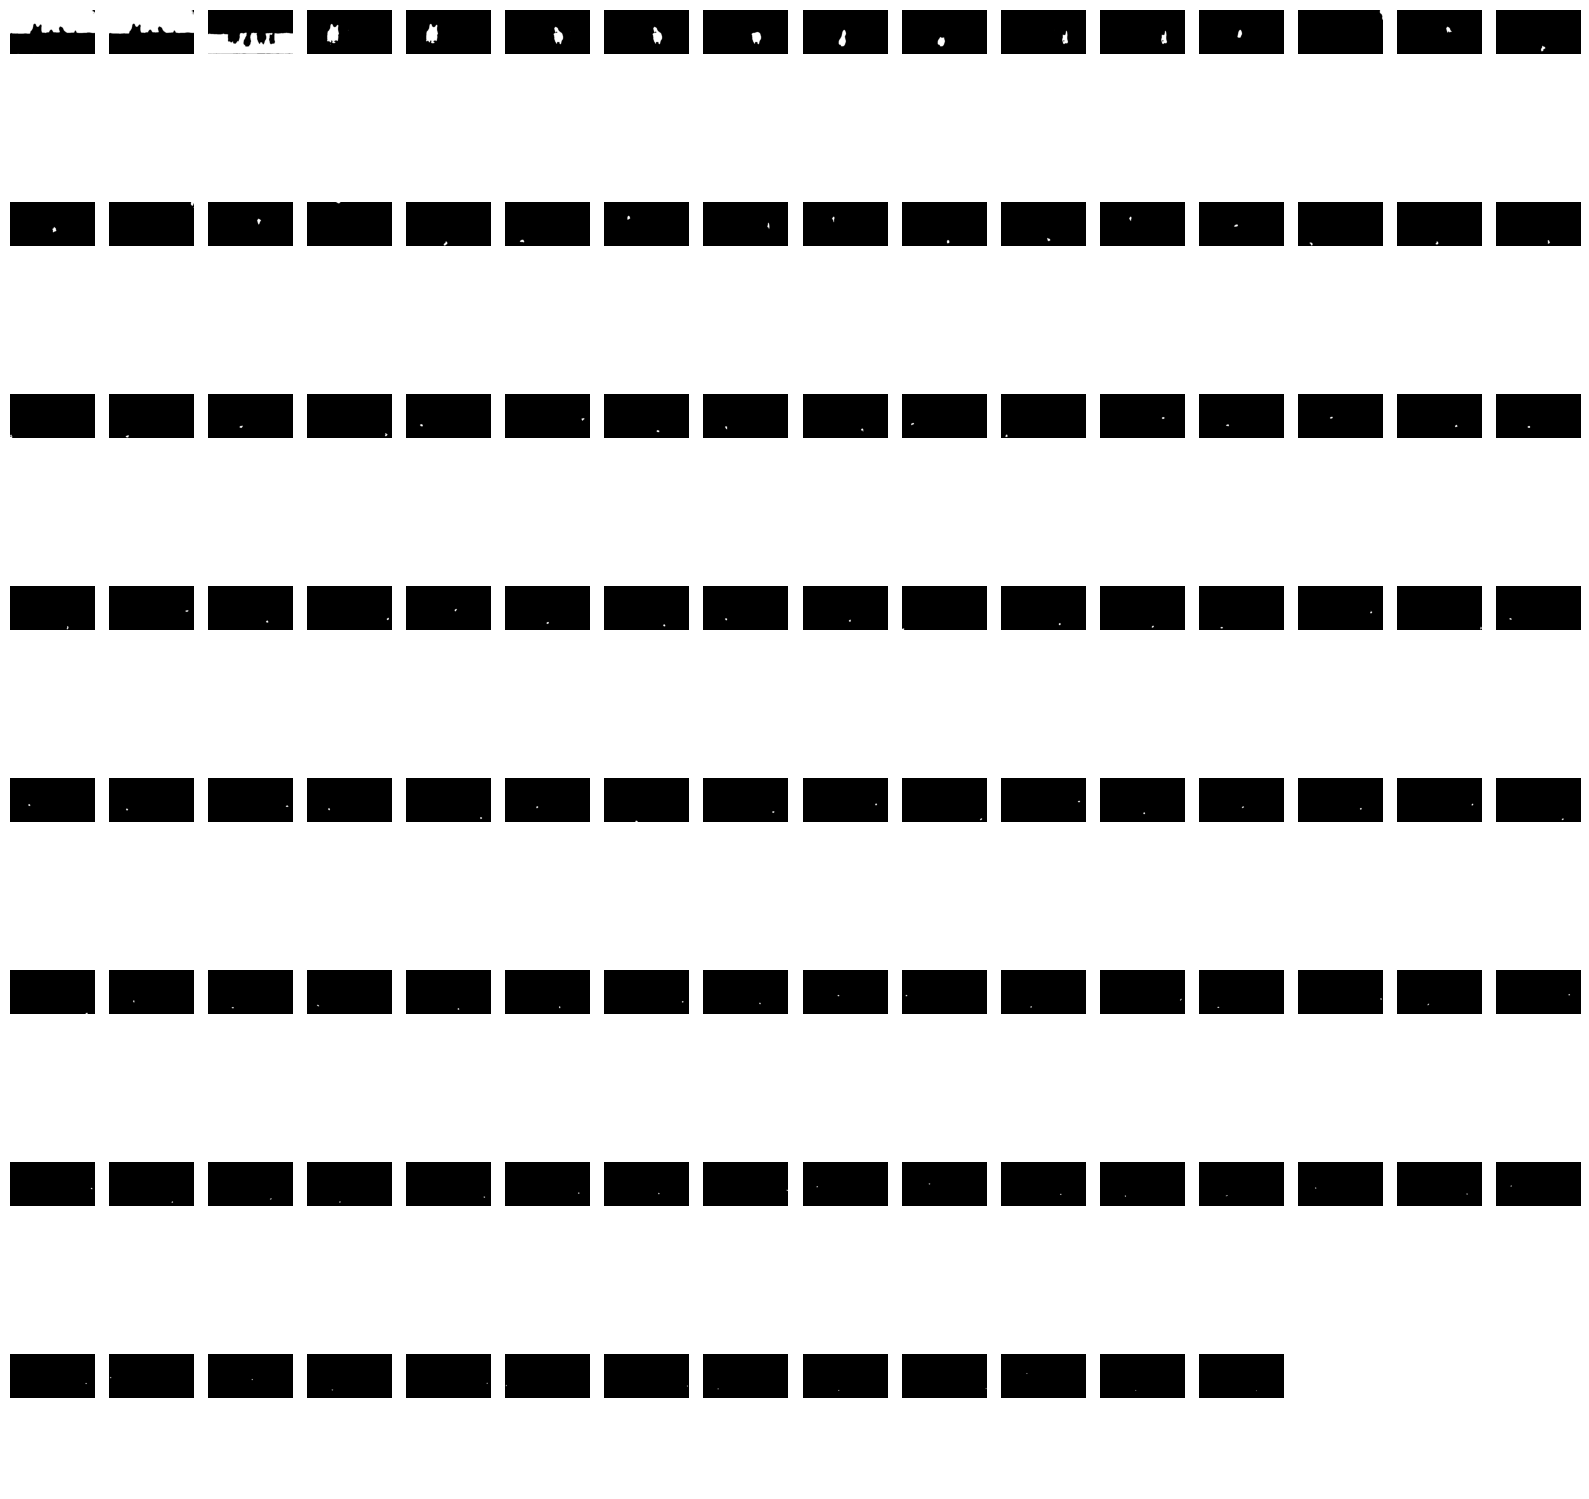

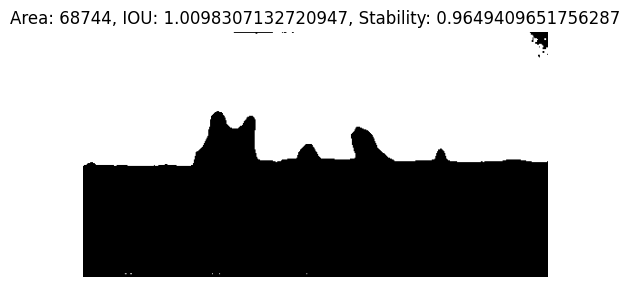

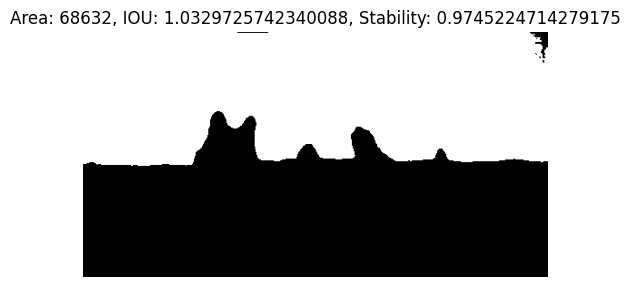

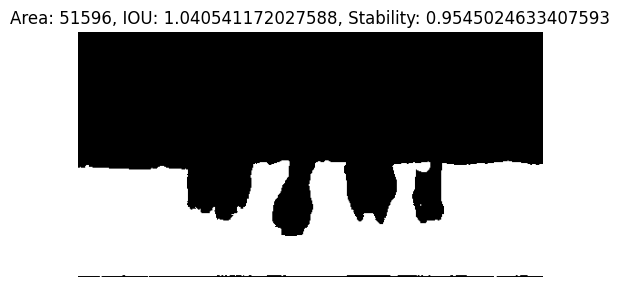

In [199]:
img, foreground_mask, background_mask = get_mask('single_image_data/og_imgs/animal_in_field.jpg')

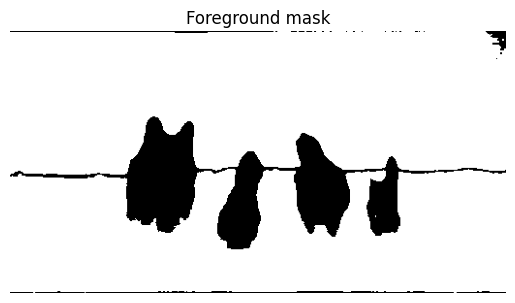

In [200]:
plt.imshow(foreground_mask, cmap='gray')
plt.title('Foreground mask')
plt.axis('off')
plt.show()

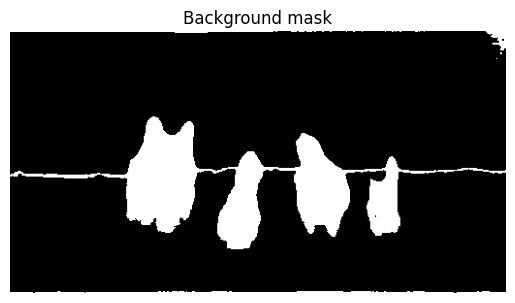

In [201]:
plt.imshow(background_mask, cmap='gray')
plt.title('Background mask')
plt.axis('off')
plt.show()

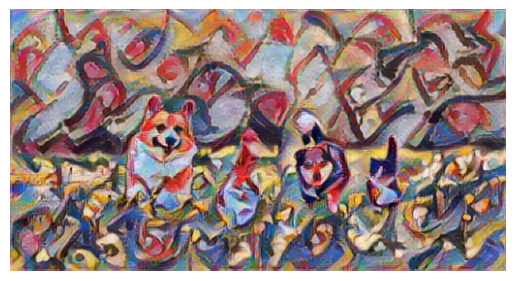

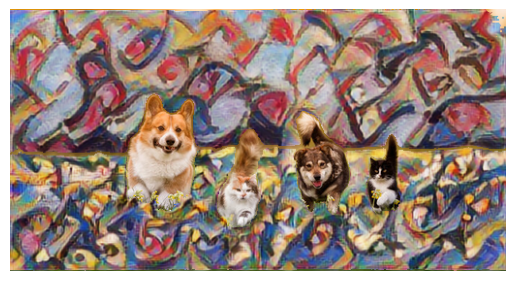

In [202]:
styled_img, final_img = get_styled_image(img, 'single_image_data/finished_styled_image.png', foreground_mask, background_mask)

plt.imshow(styled_img)
plt.axis('off')
plt.show()

plt.imshow(final_img)
plt.axis('off')
plt.show()

In [203]:
final_pil = PIL.Image.fromarray(final_img.astype(np.uint8))
final_pil.save("single_image_data/final_image.png")

# GIF Frames Segmentation and Styling

22
Saved grid to masks_grid.png


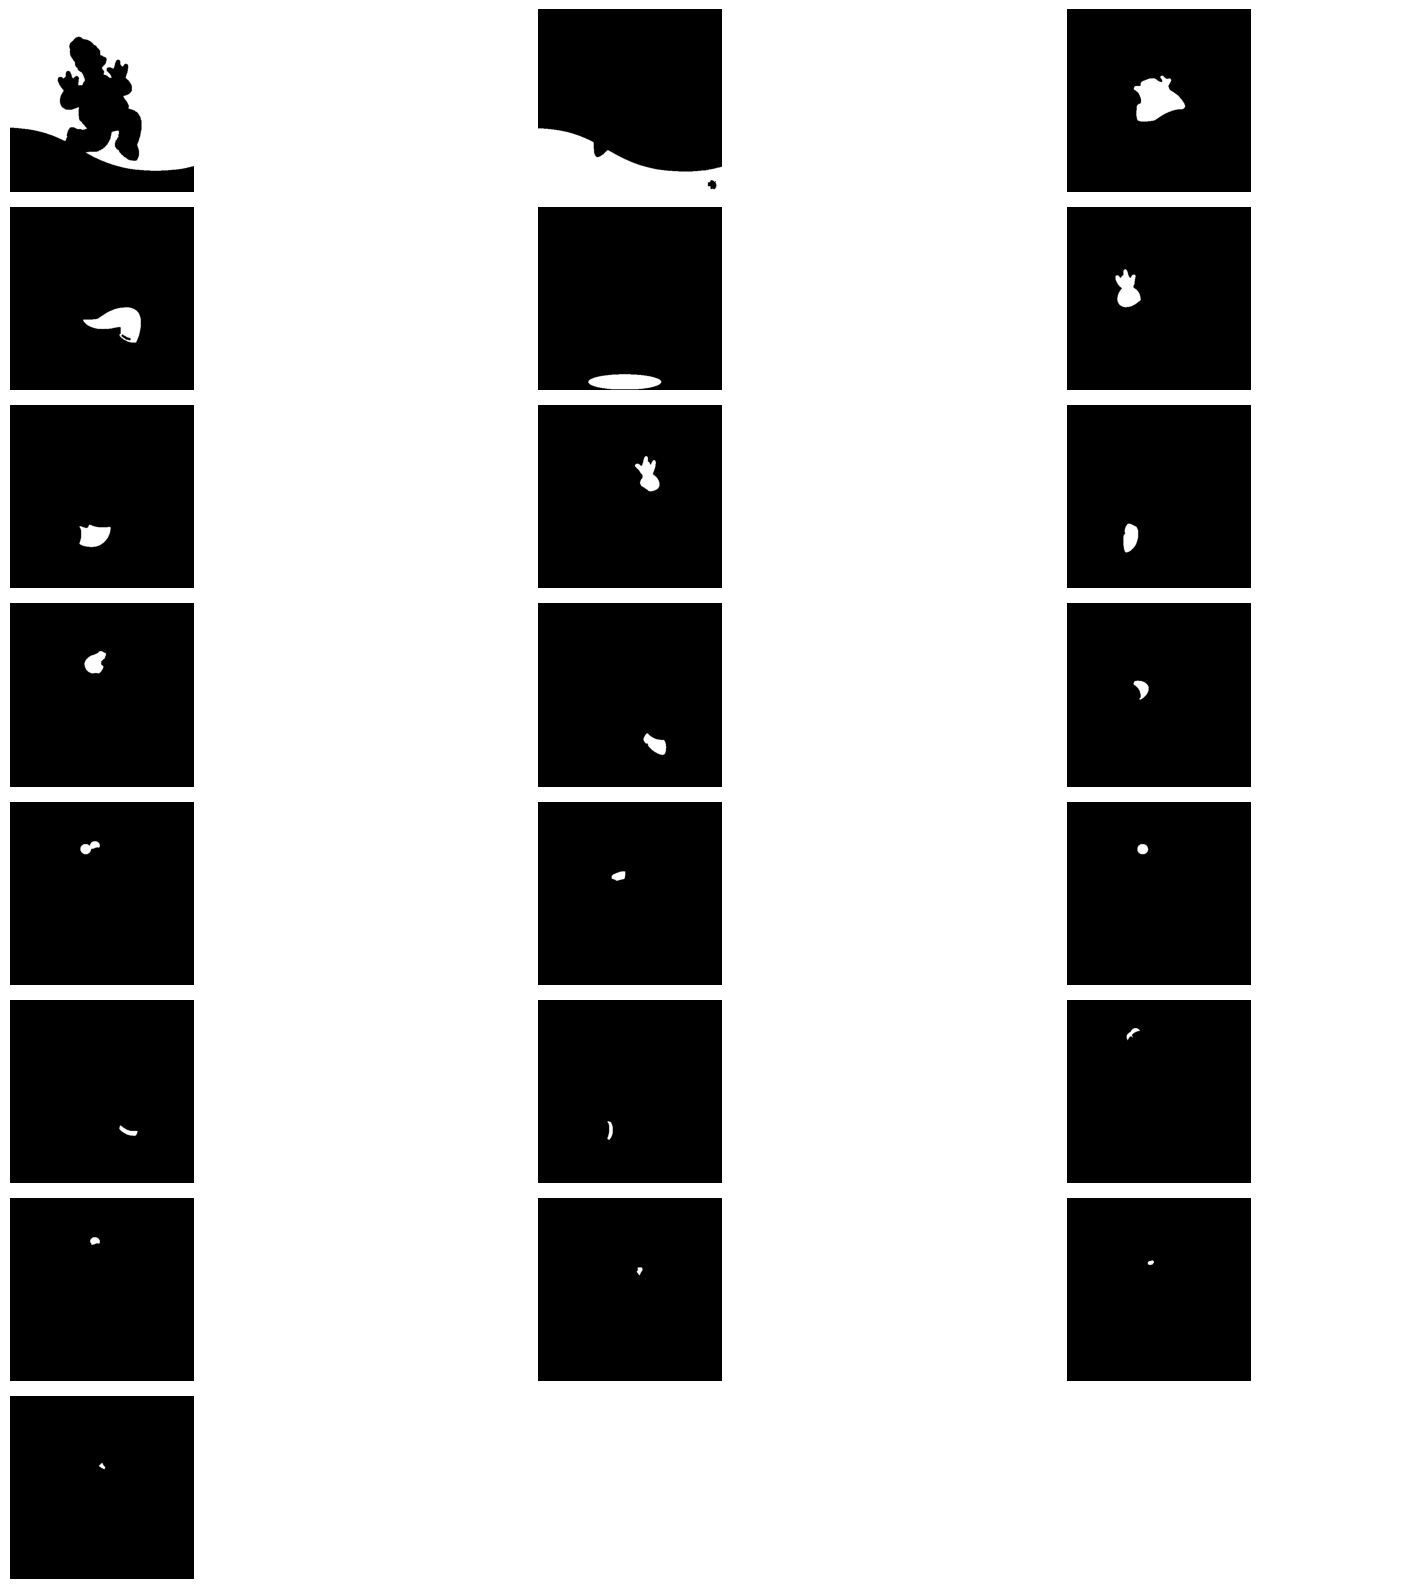

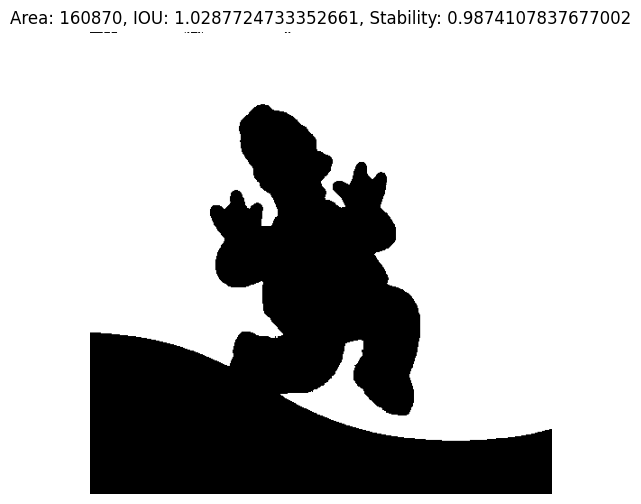

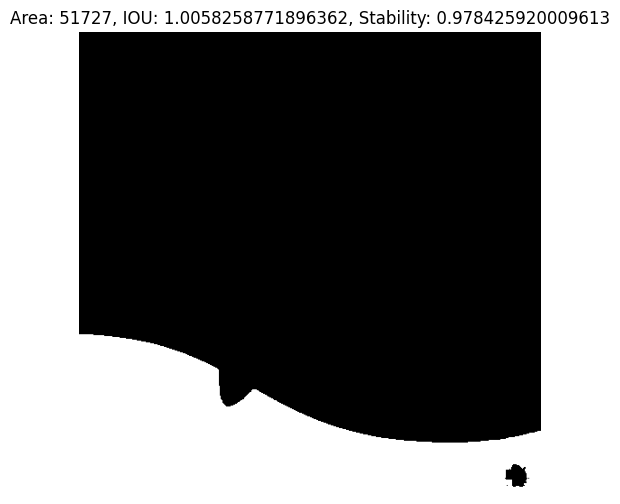

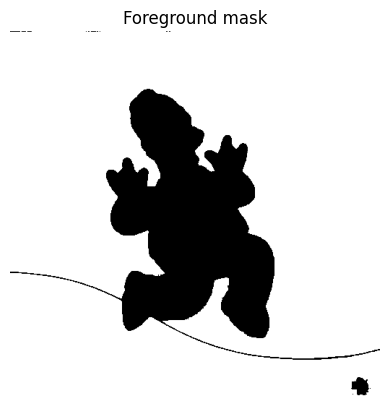

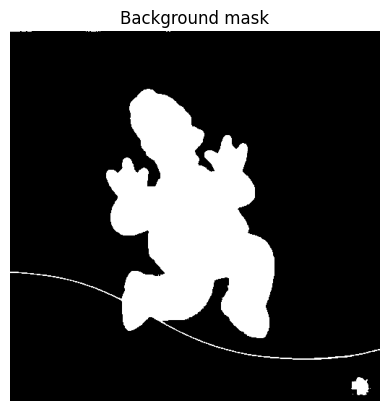

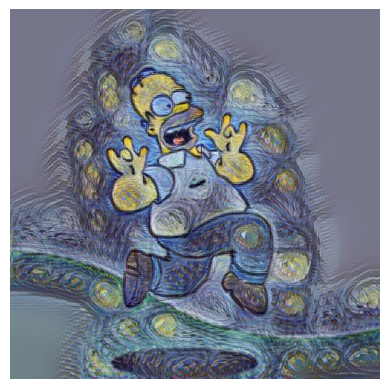

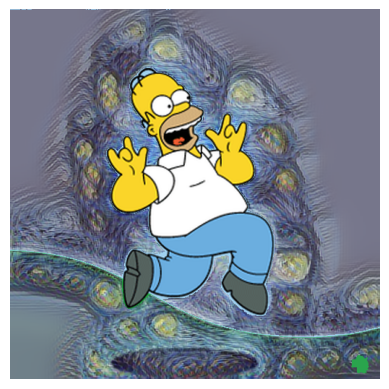

21
Saved grid to masks_grid.png


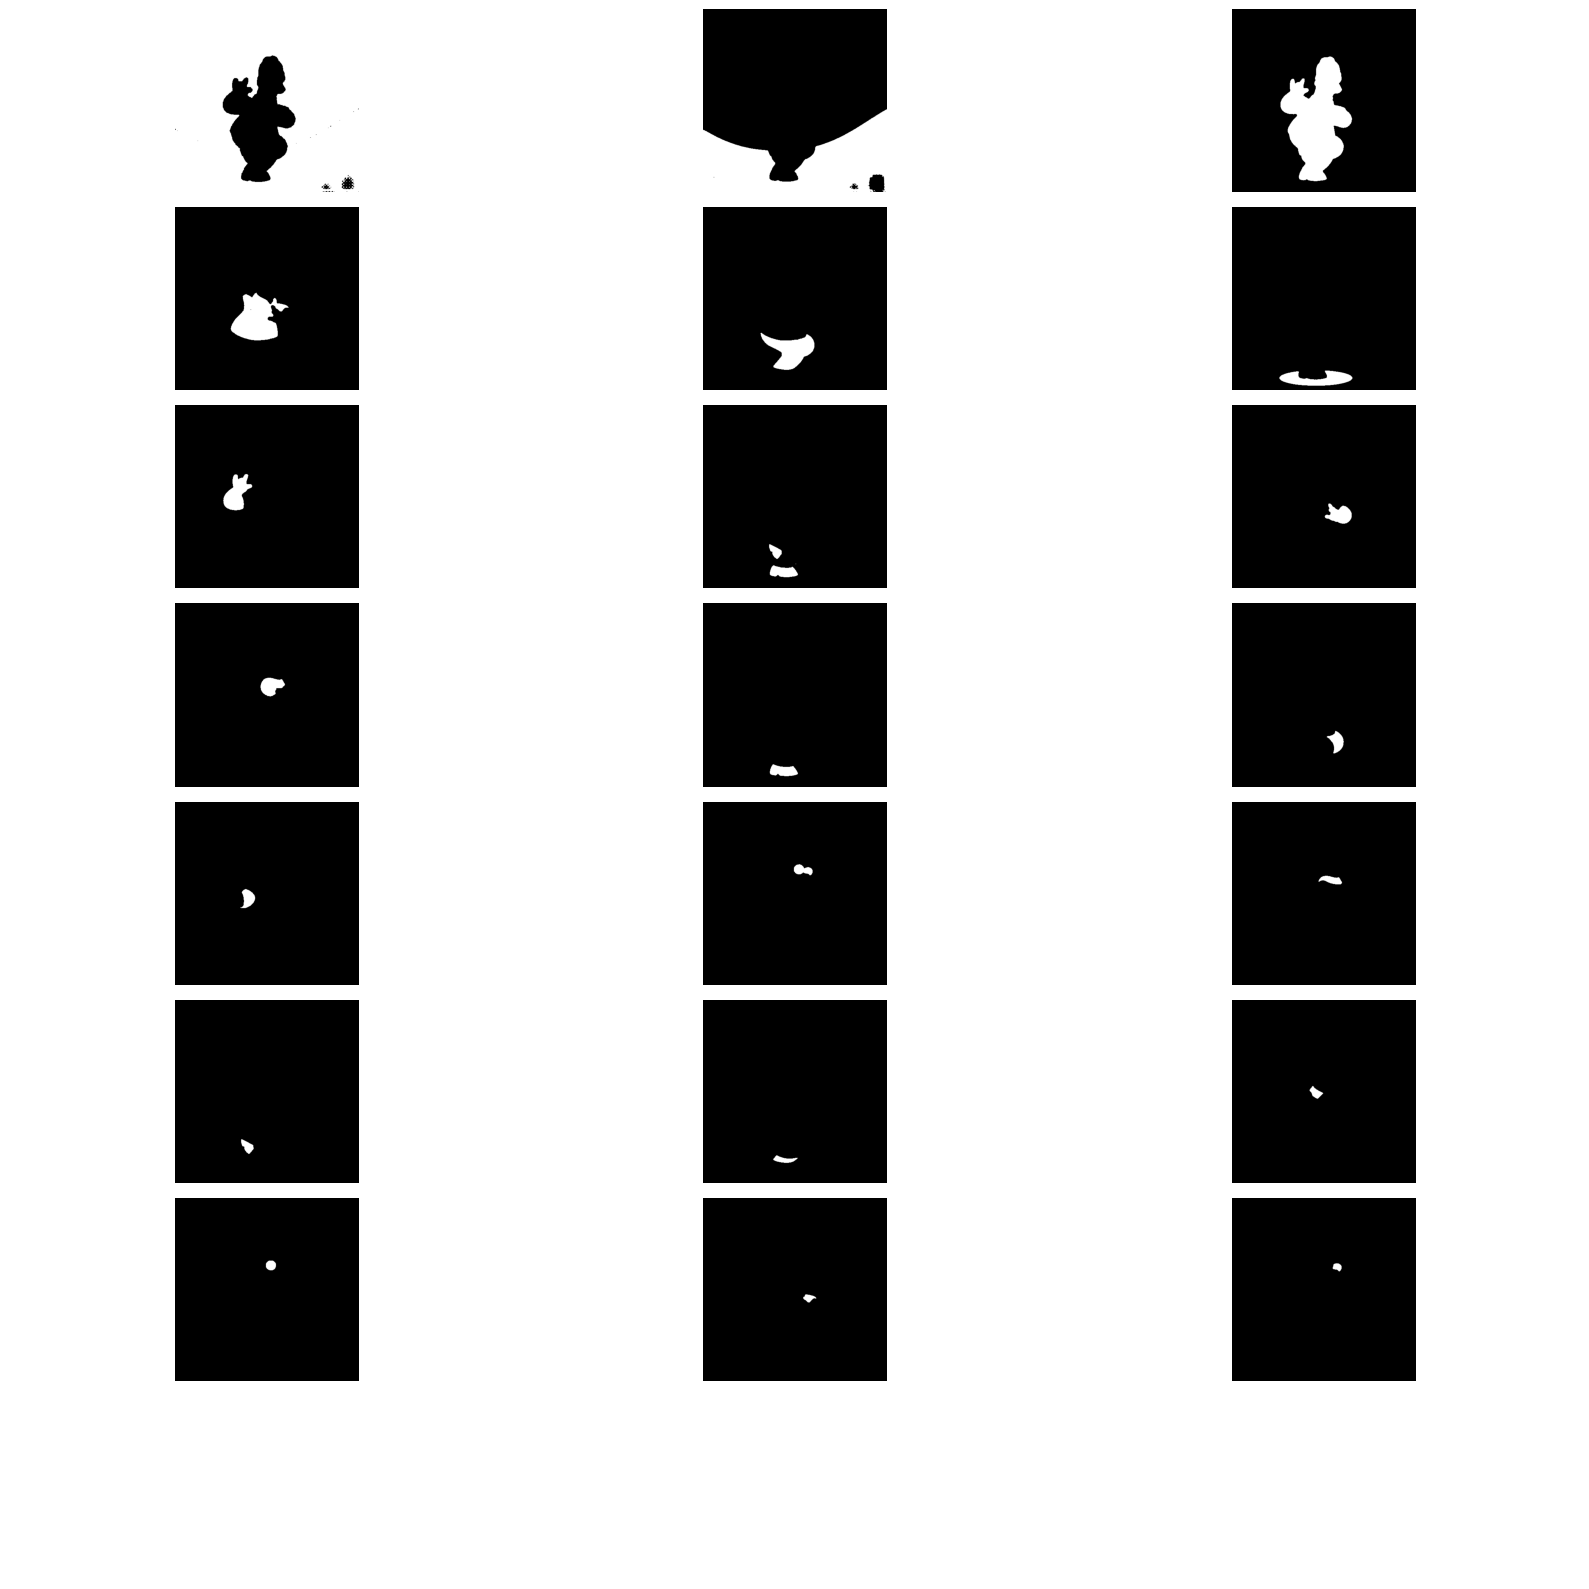

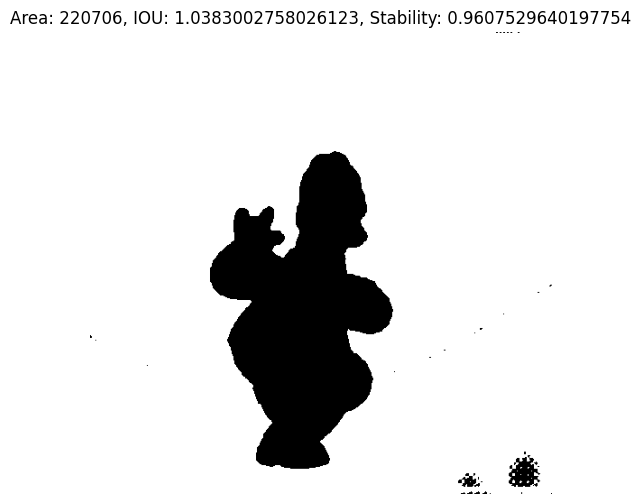

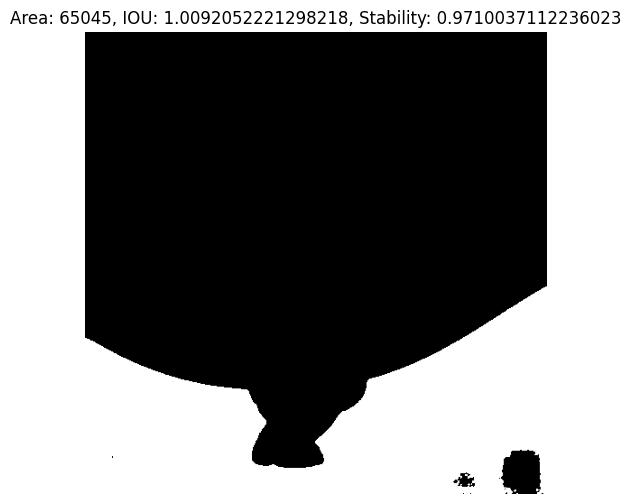

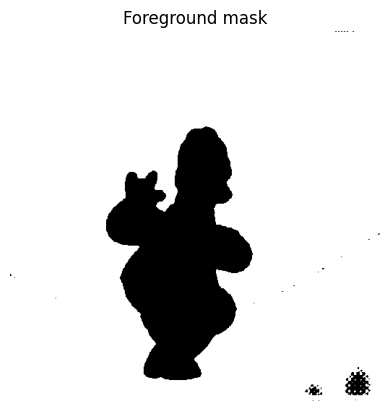

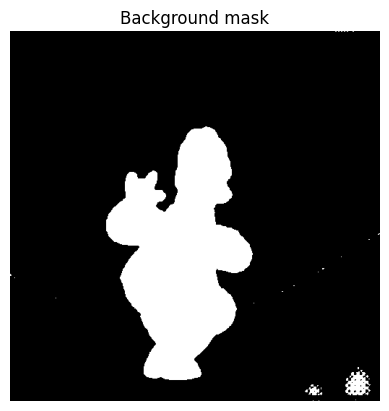

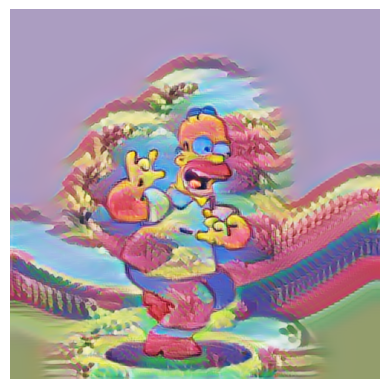

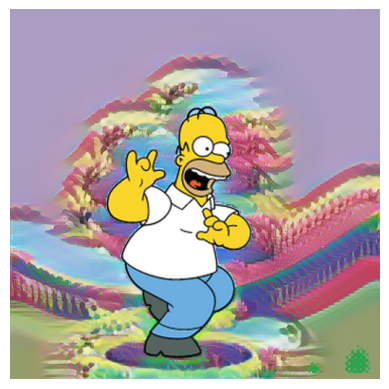

22
Saved grid to masks_grid.png


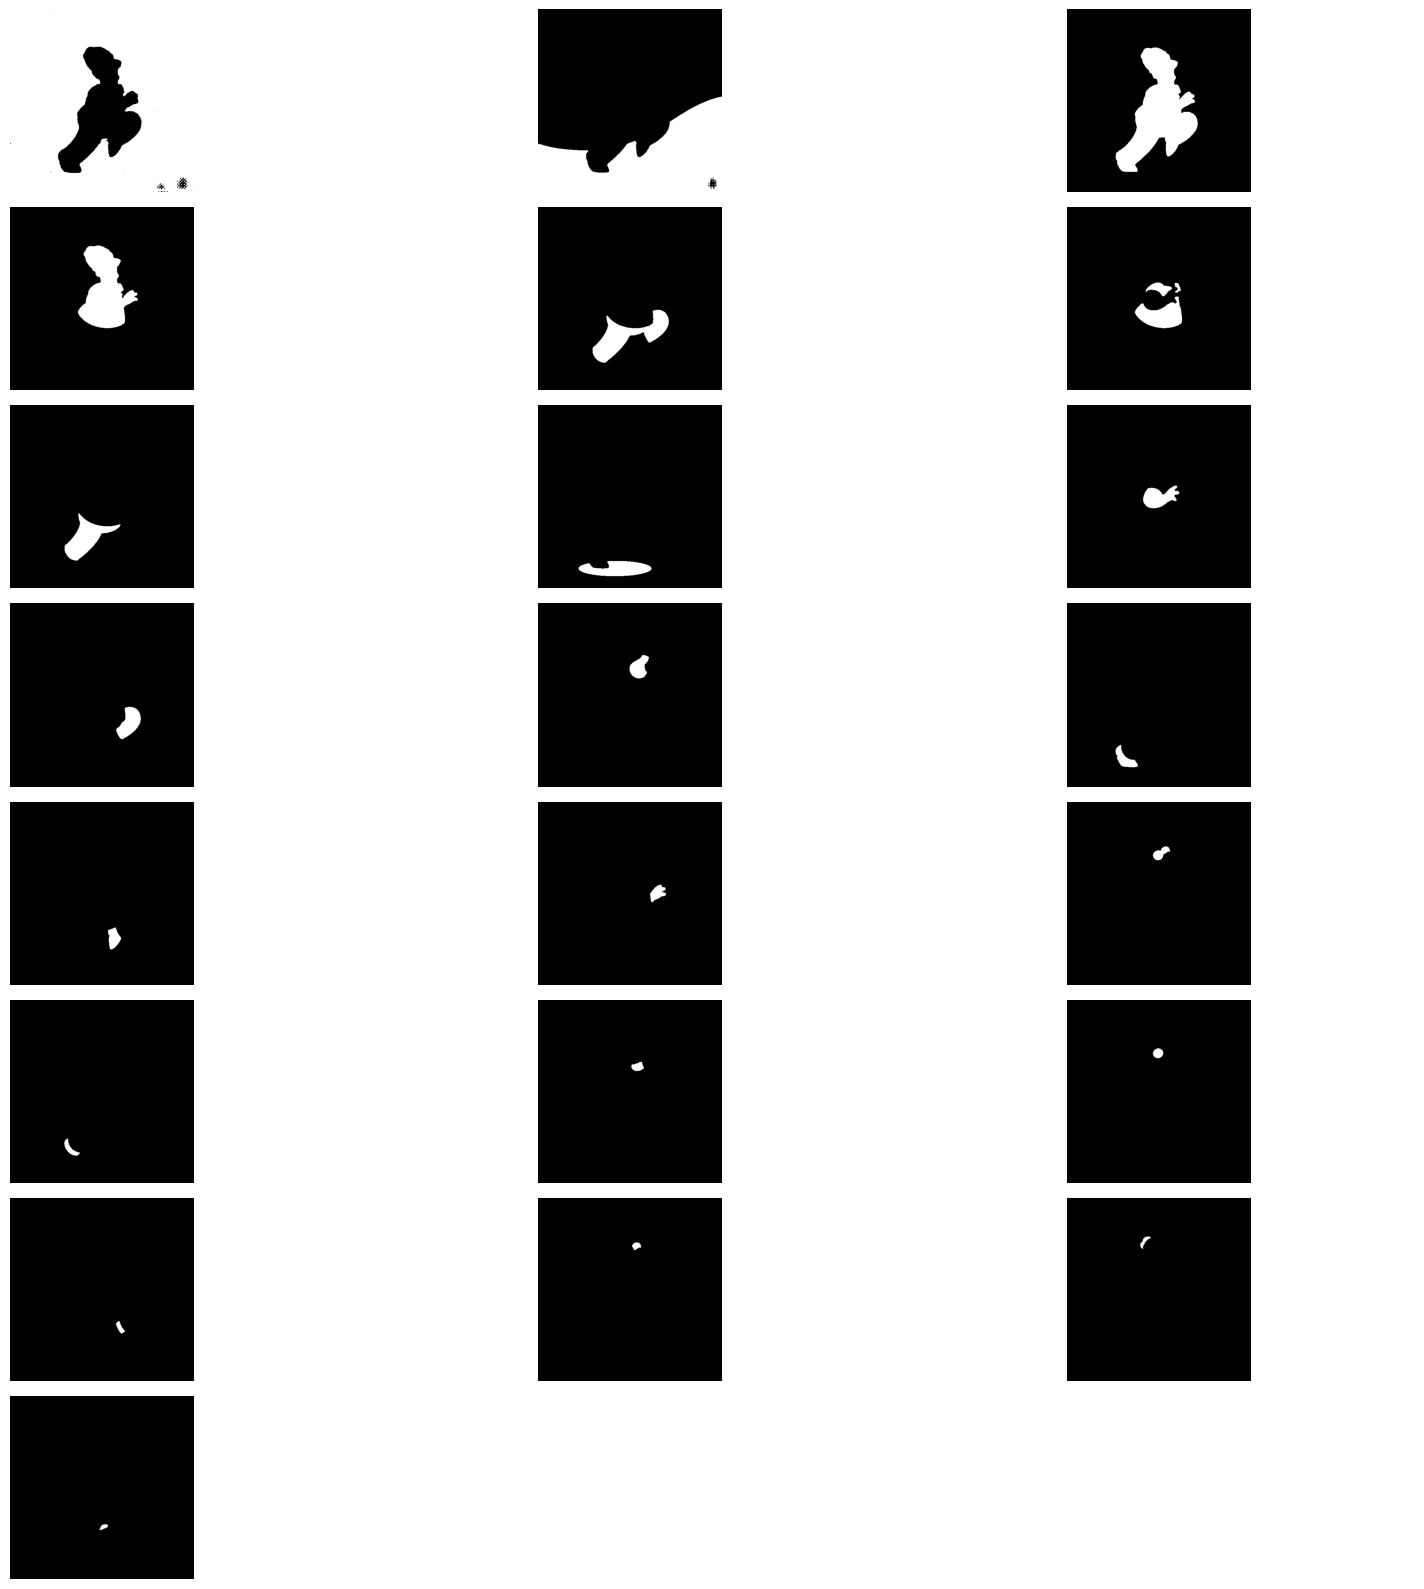

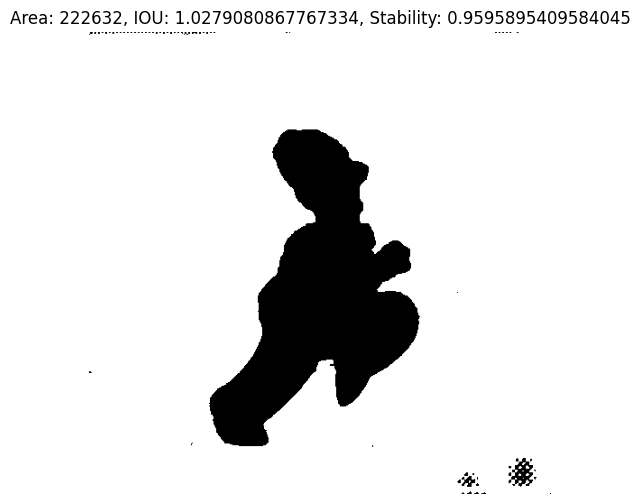

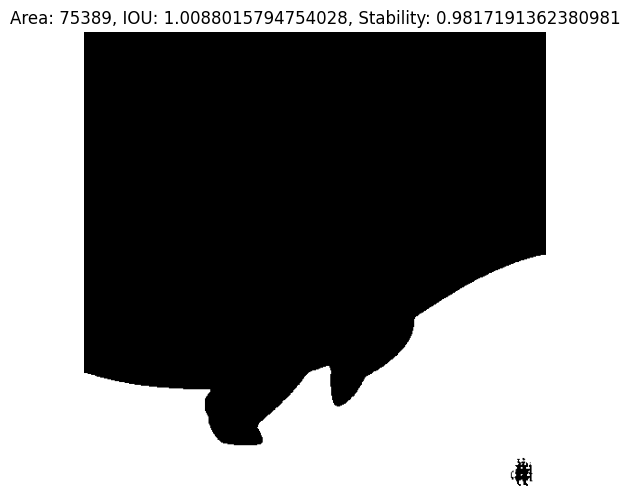

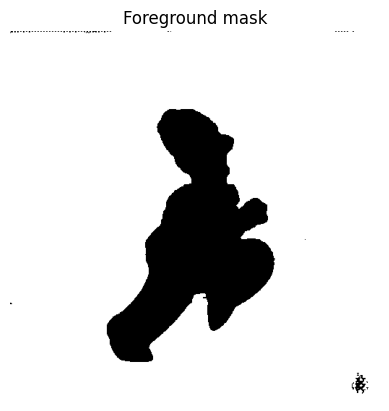

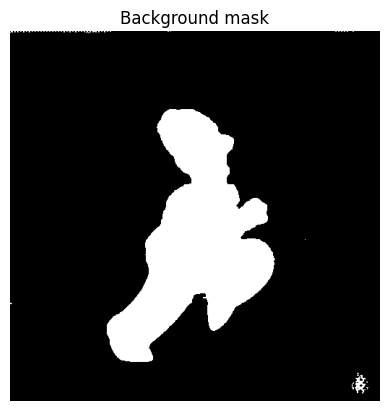

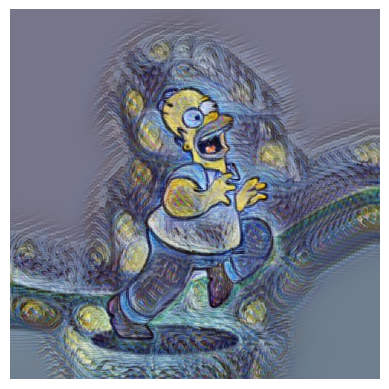

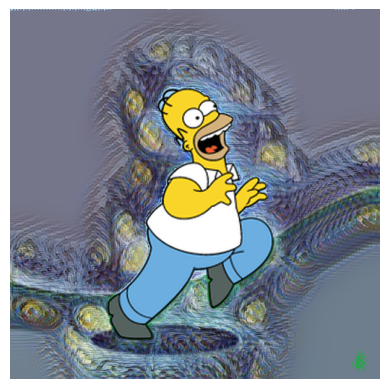

22
Saved grid to masks_grid.png


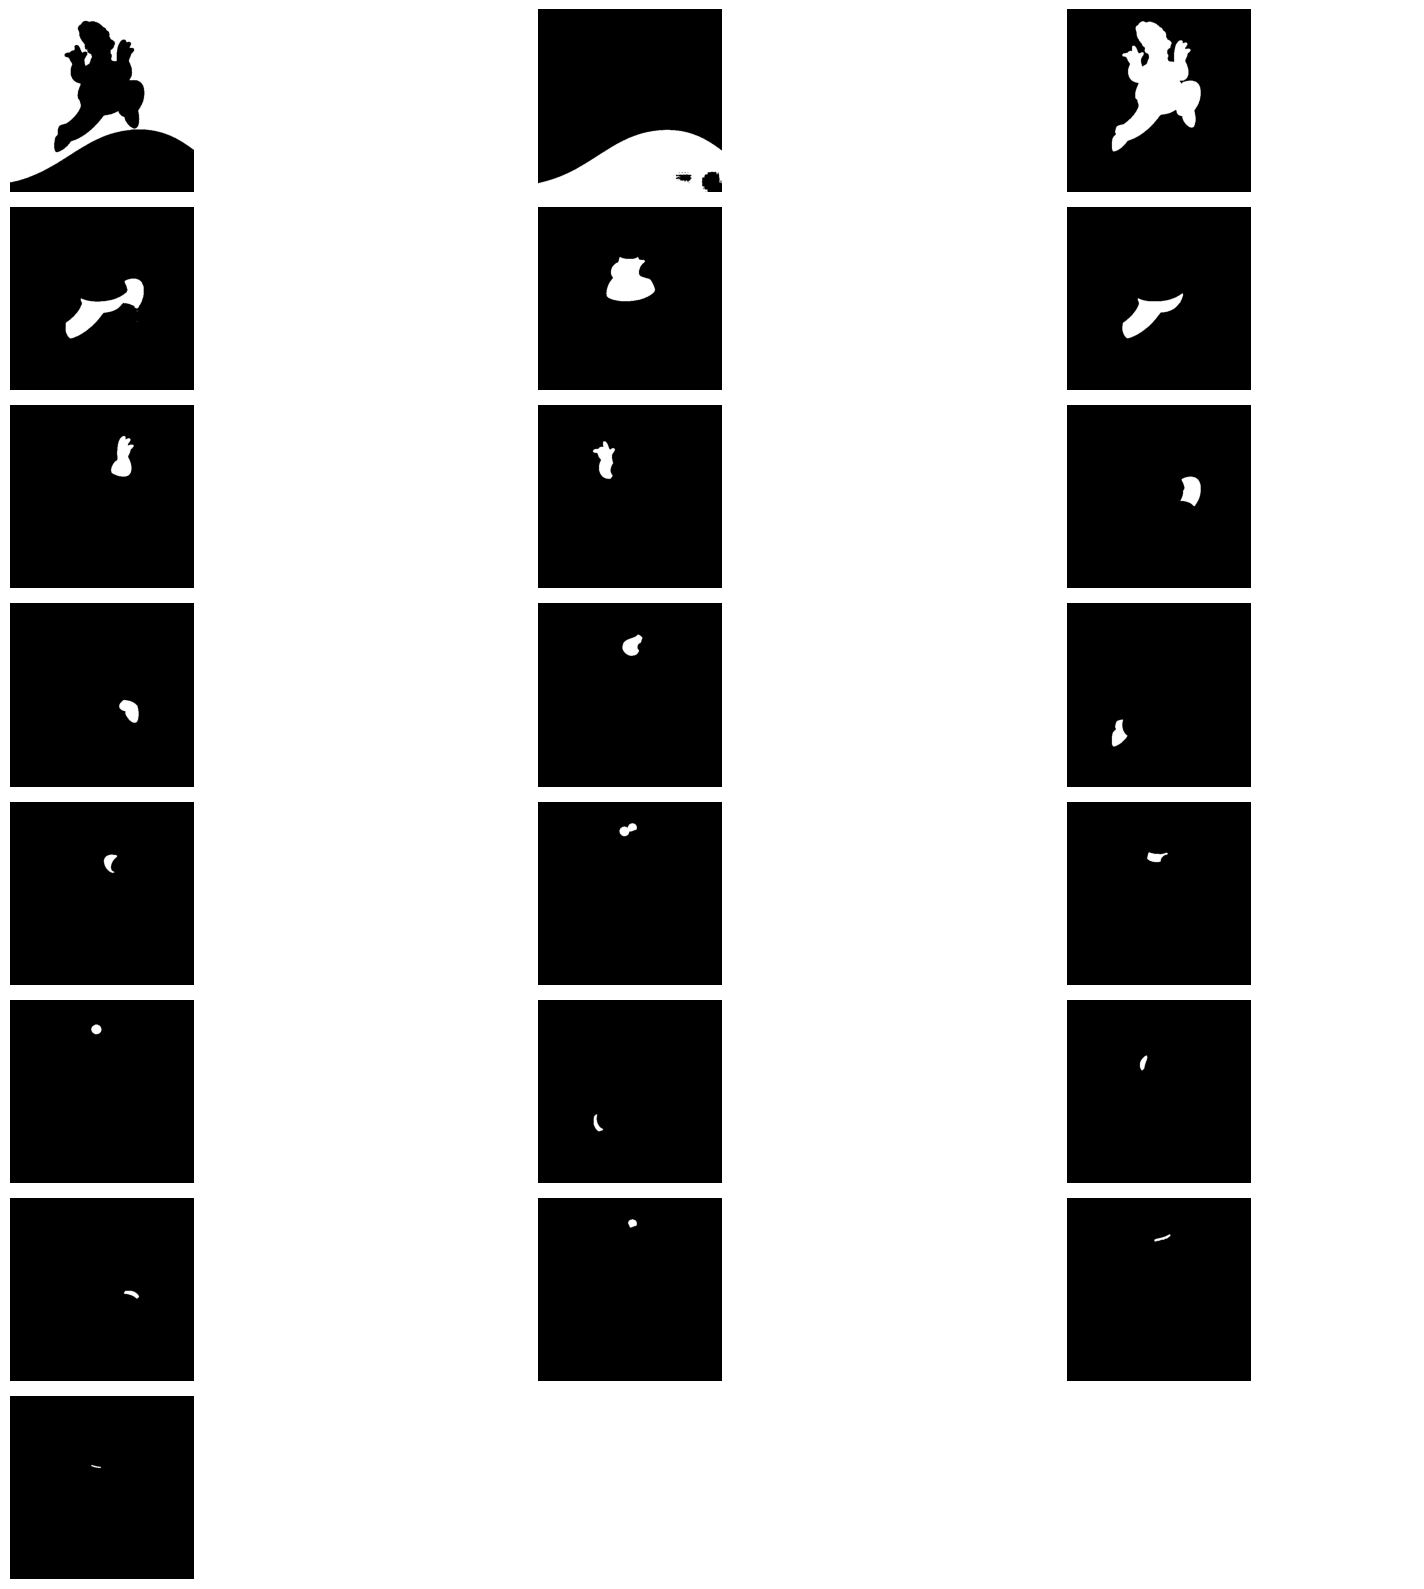

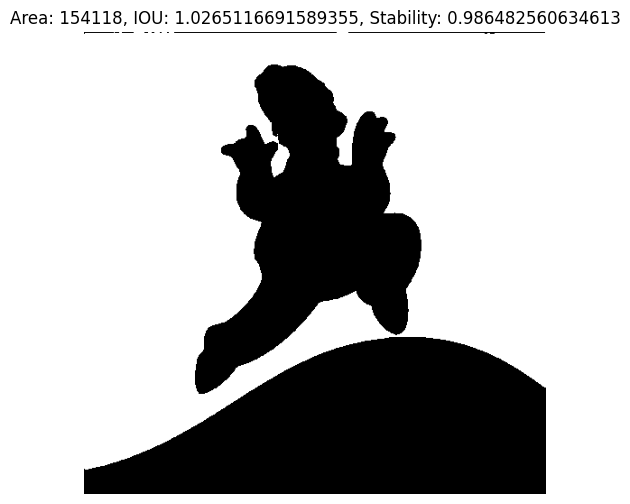

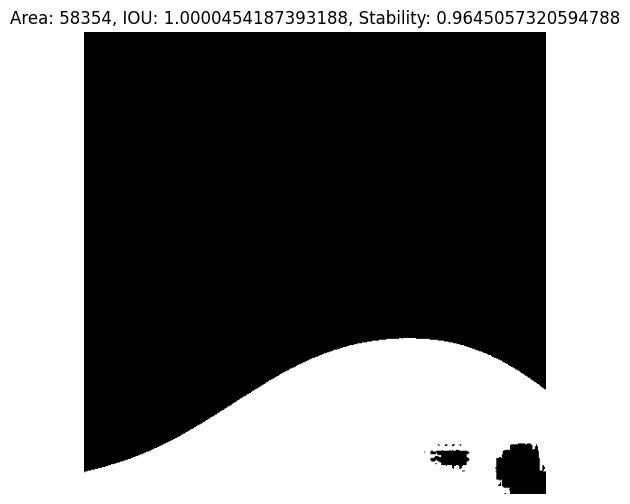

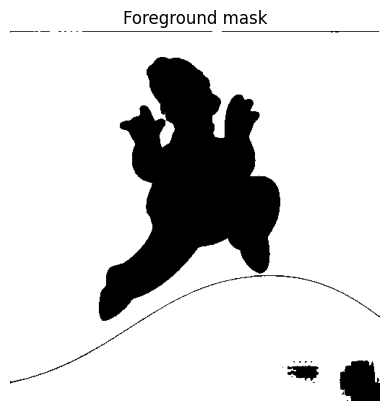

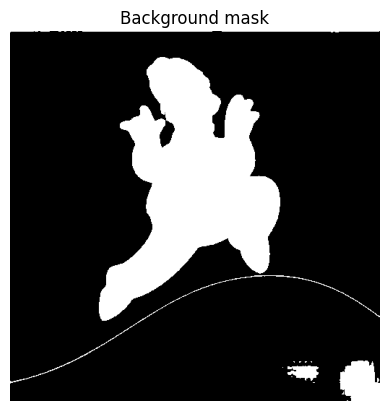

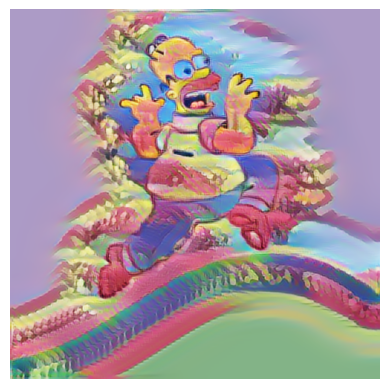

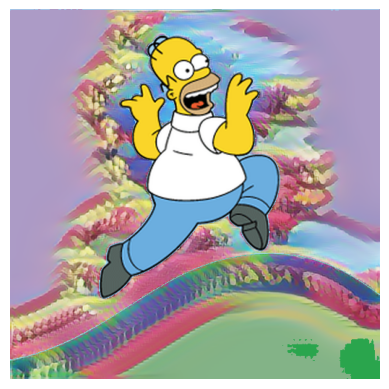

25
Saved grid to masks_grid.png


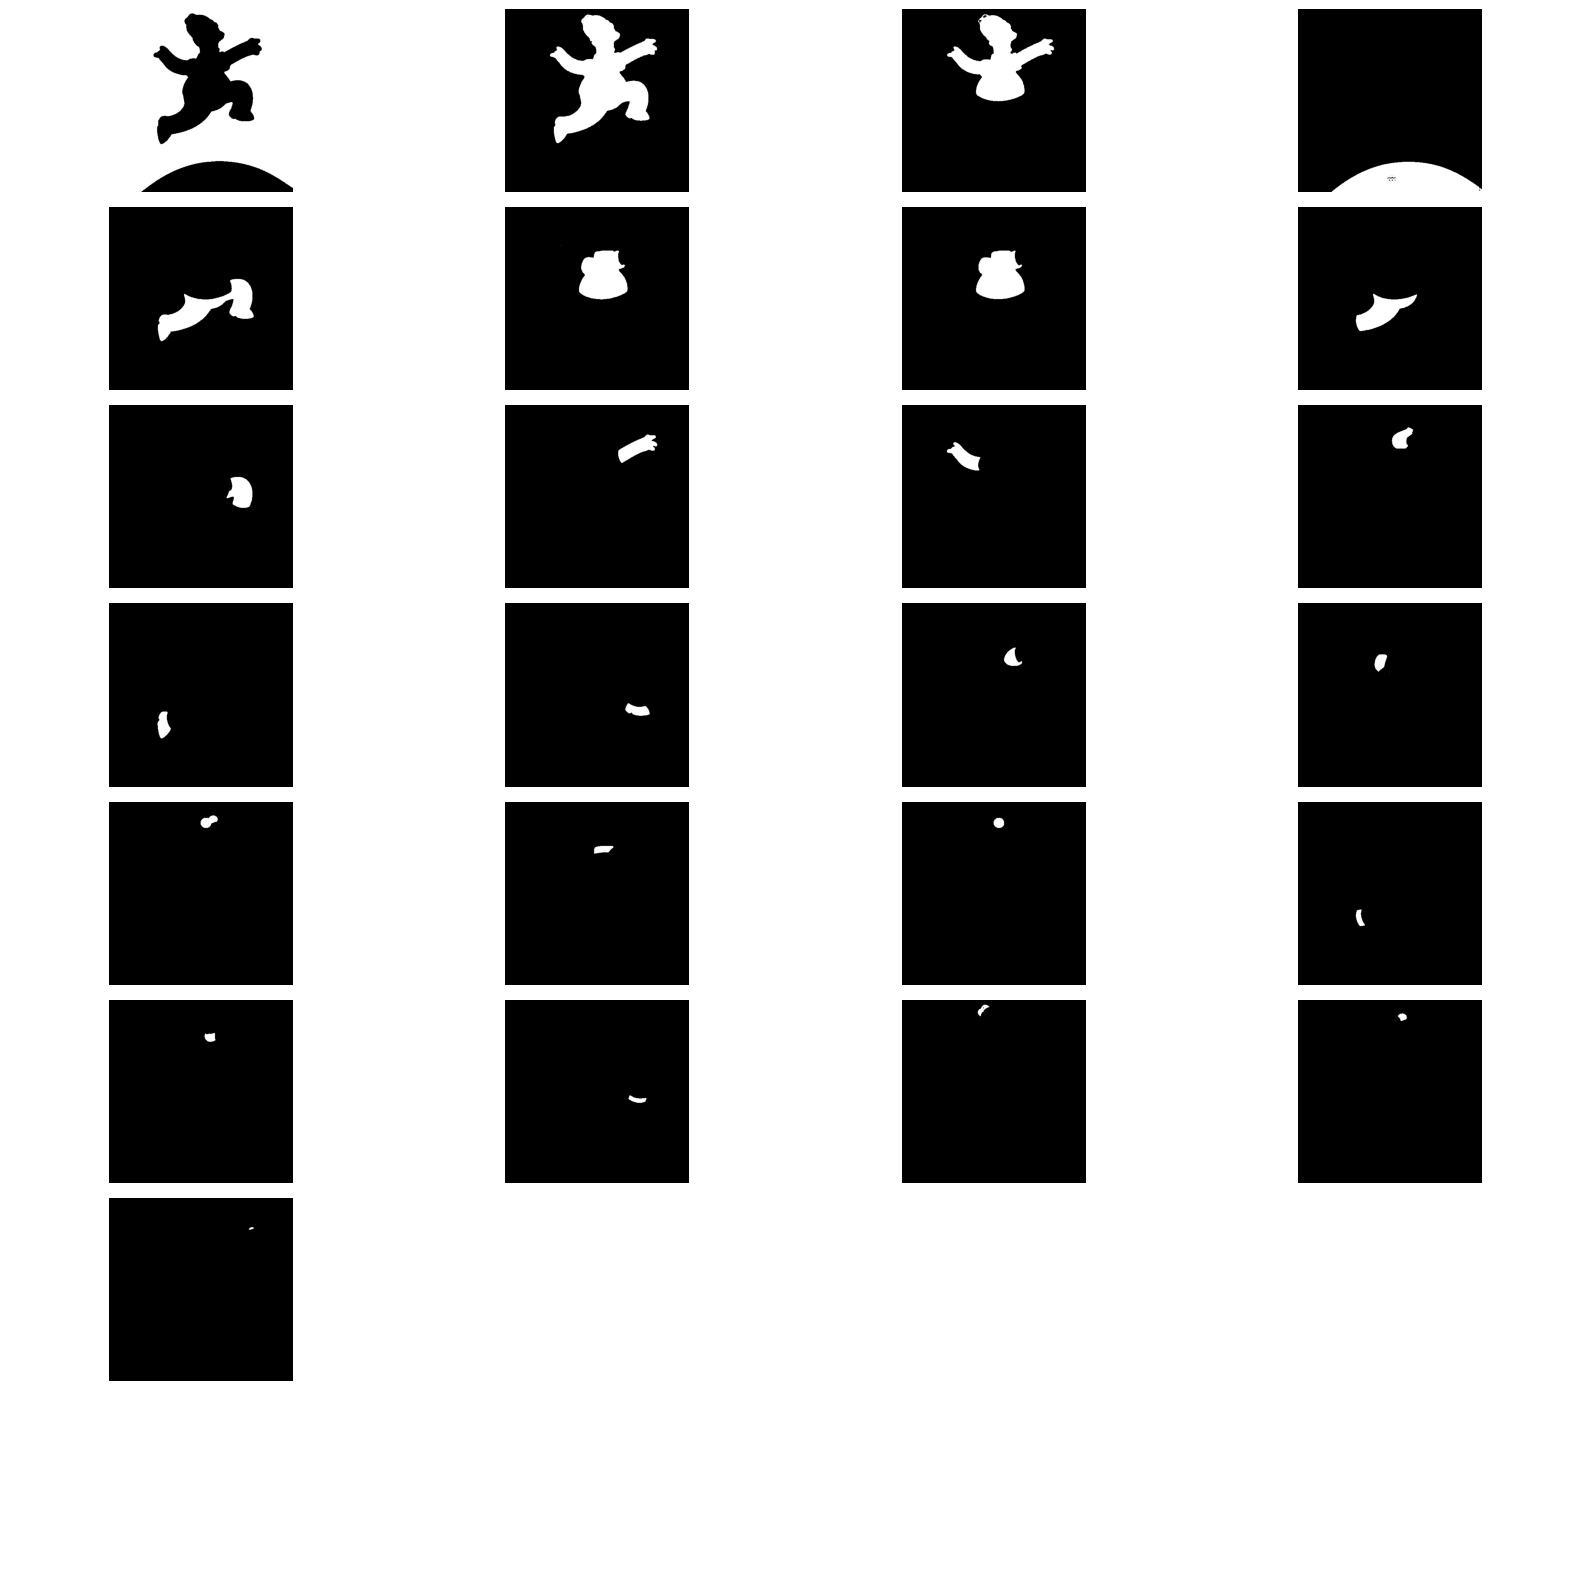

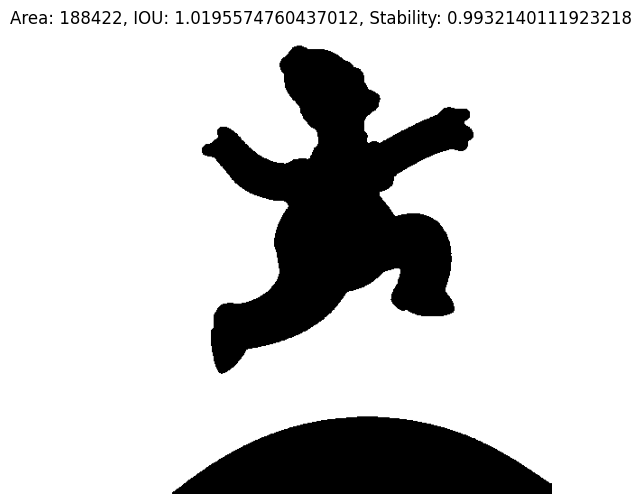

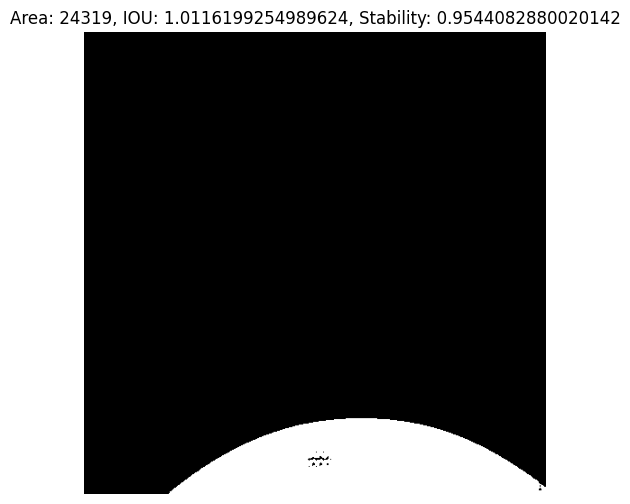

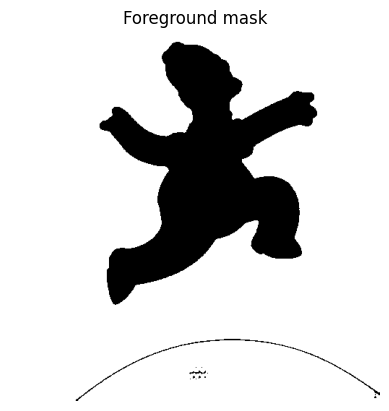

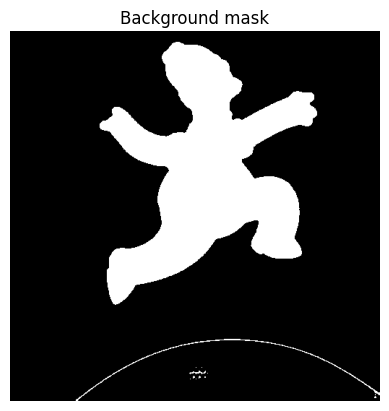

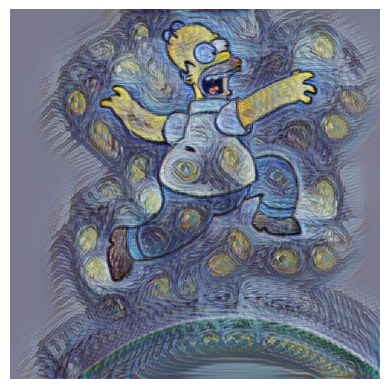

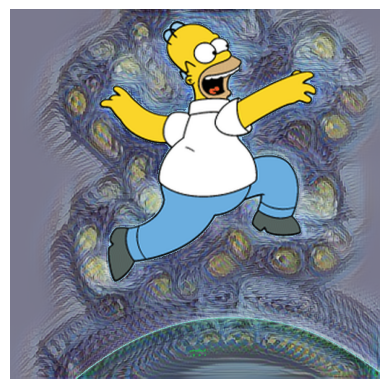

18
Saved grid to masks_grid.png


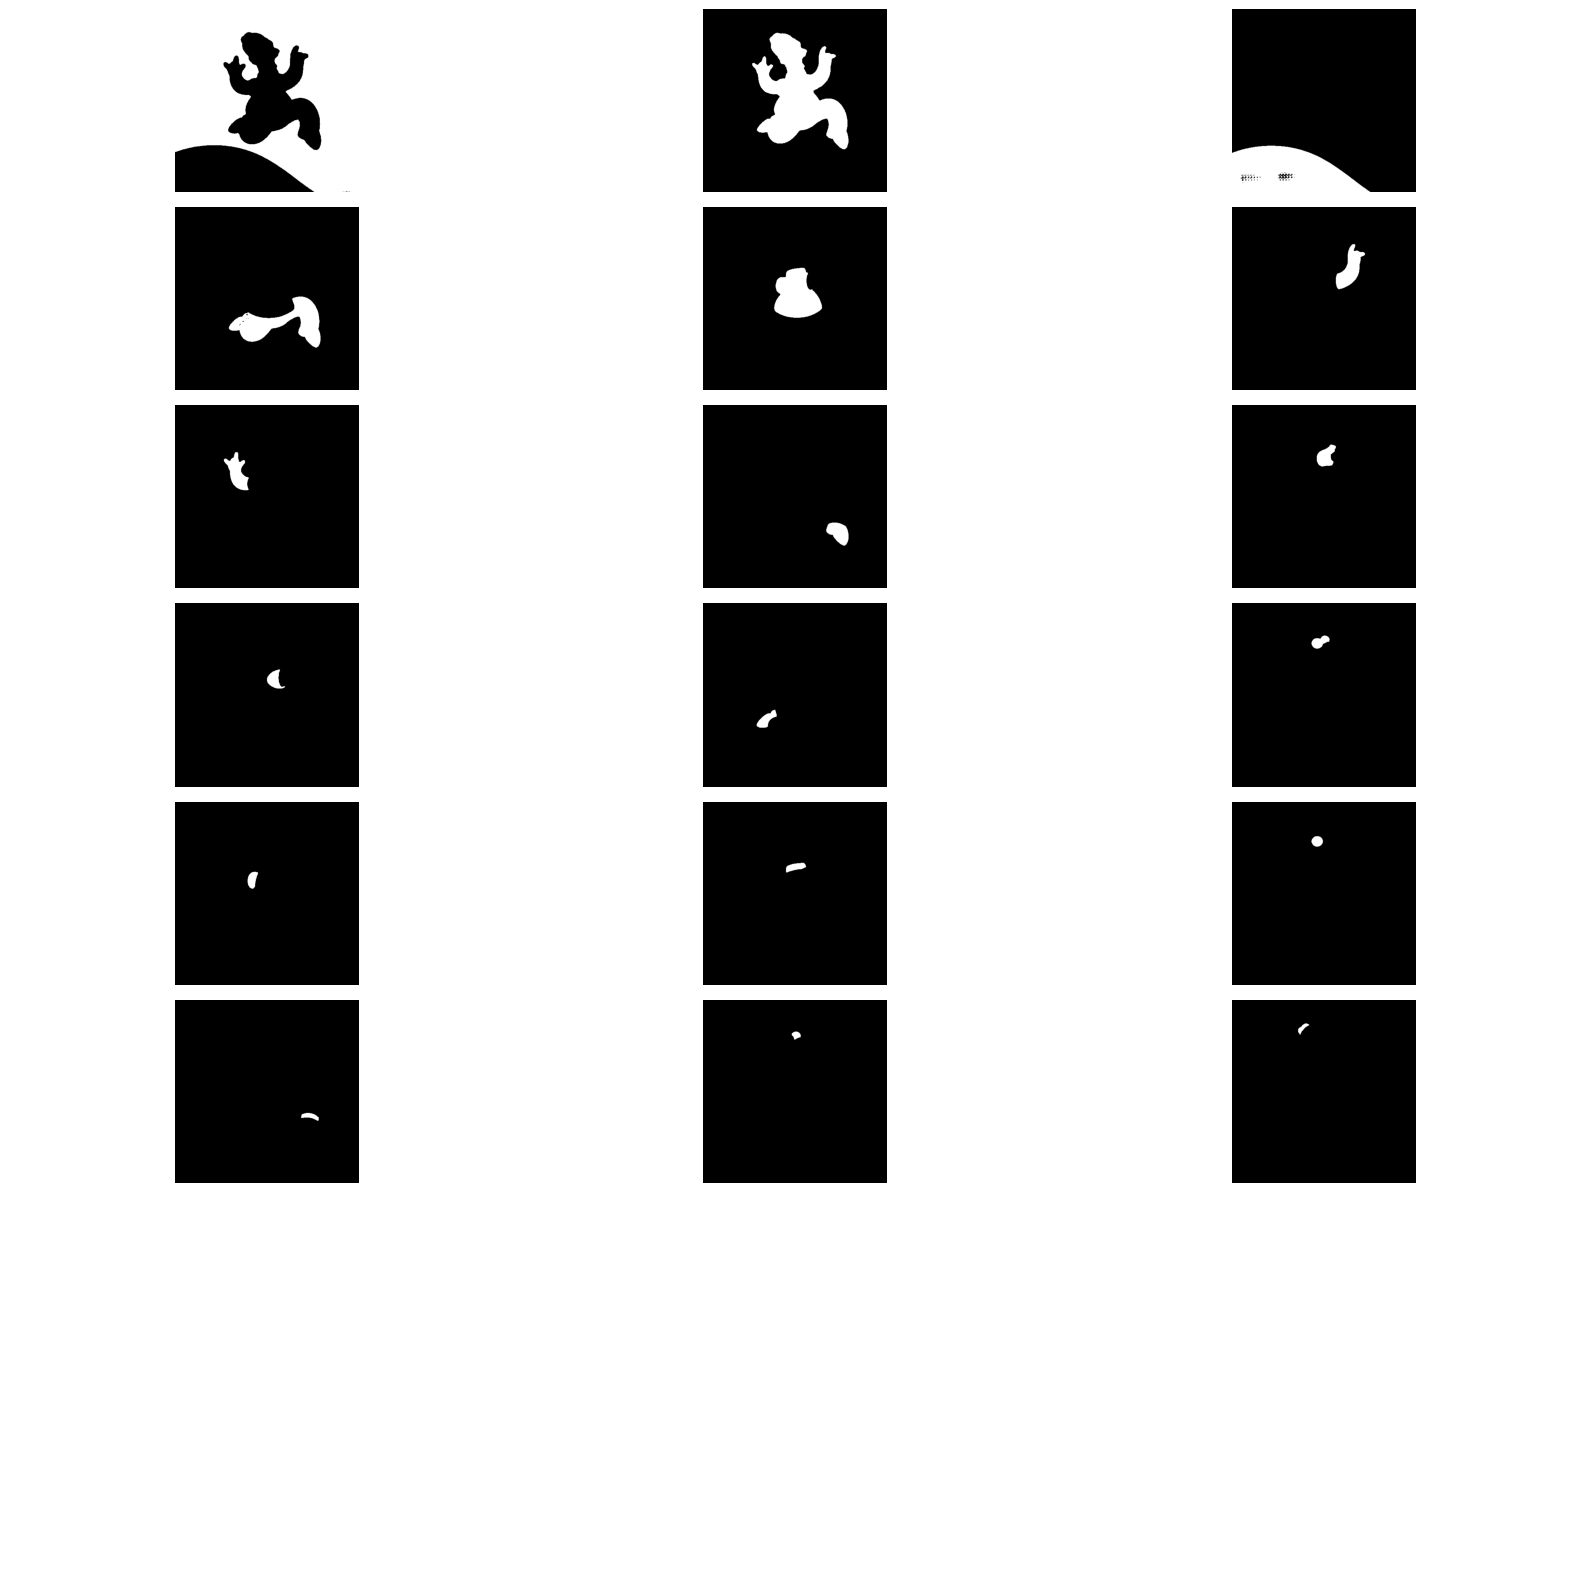

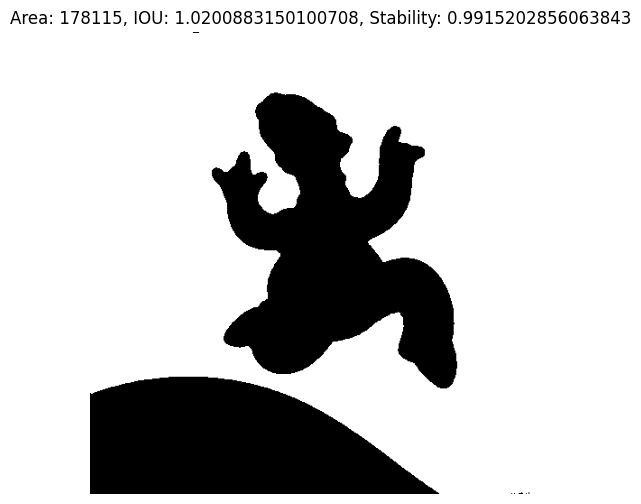

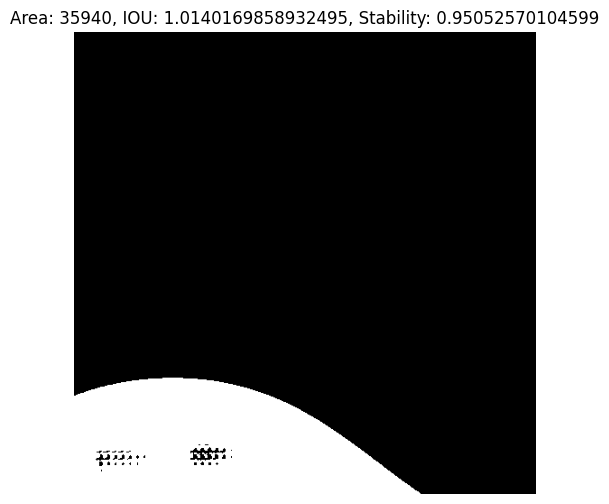

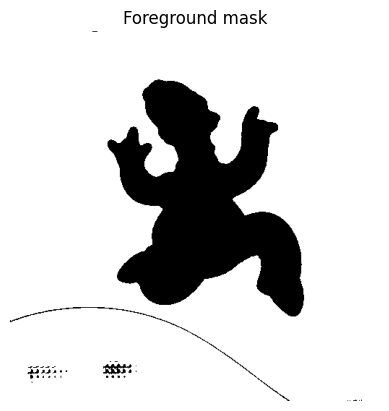

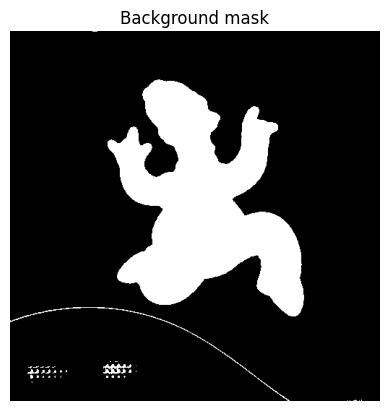

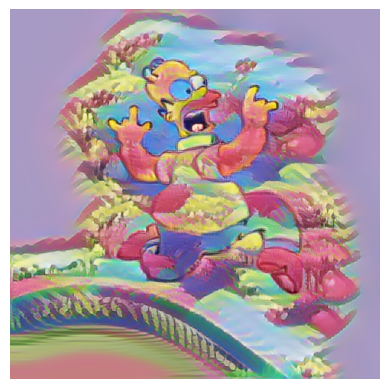

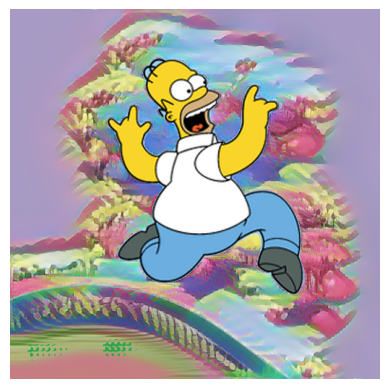

26
Saved grid to masks_grid.png


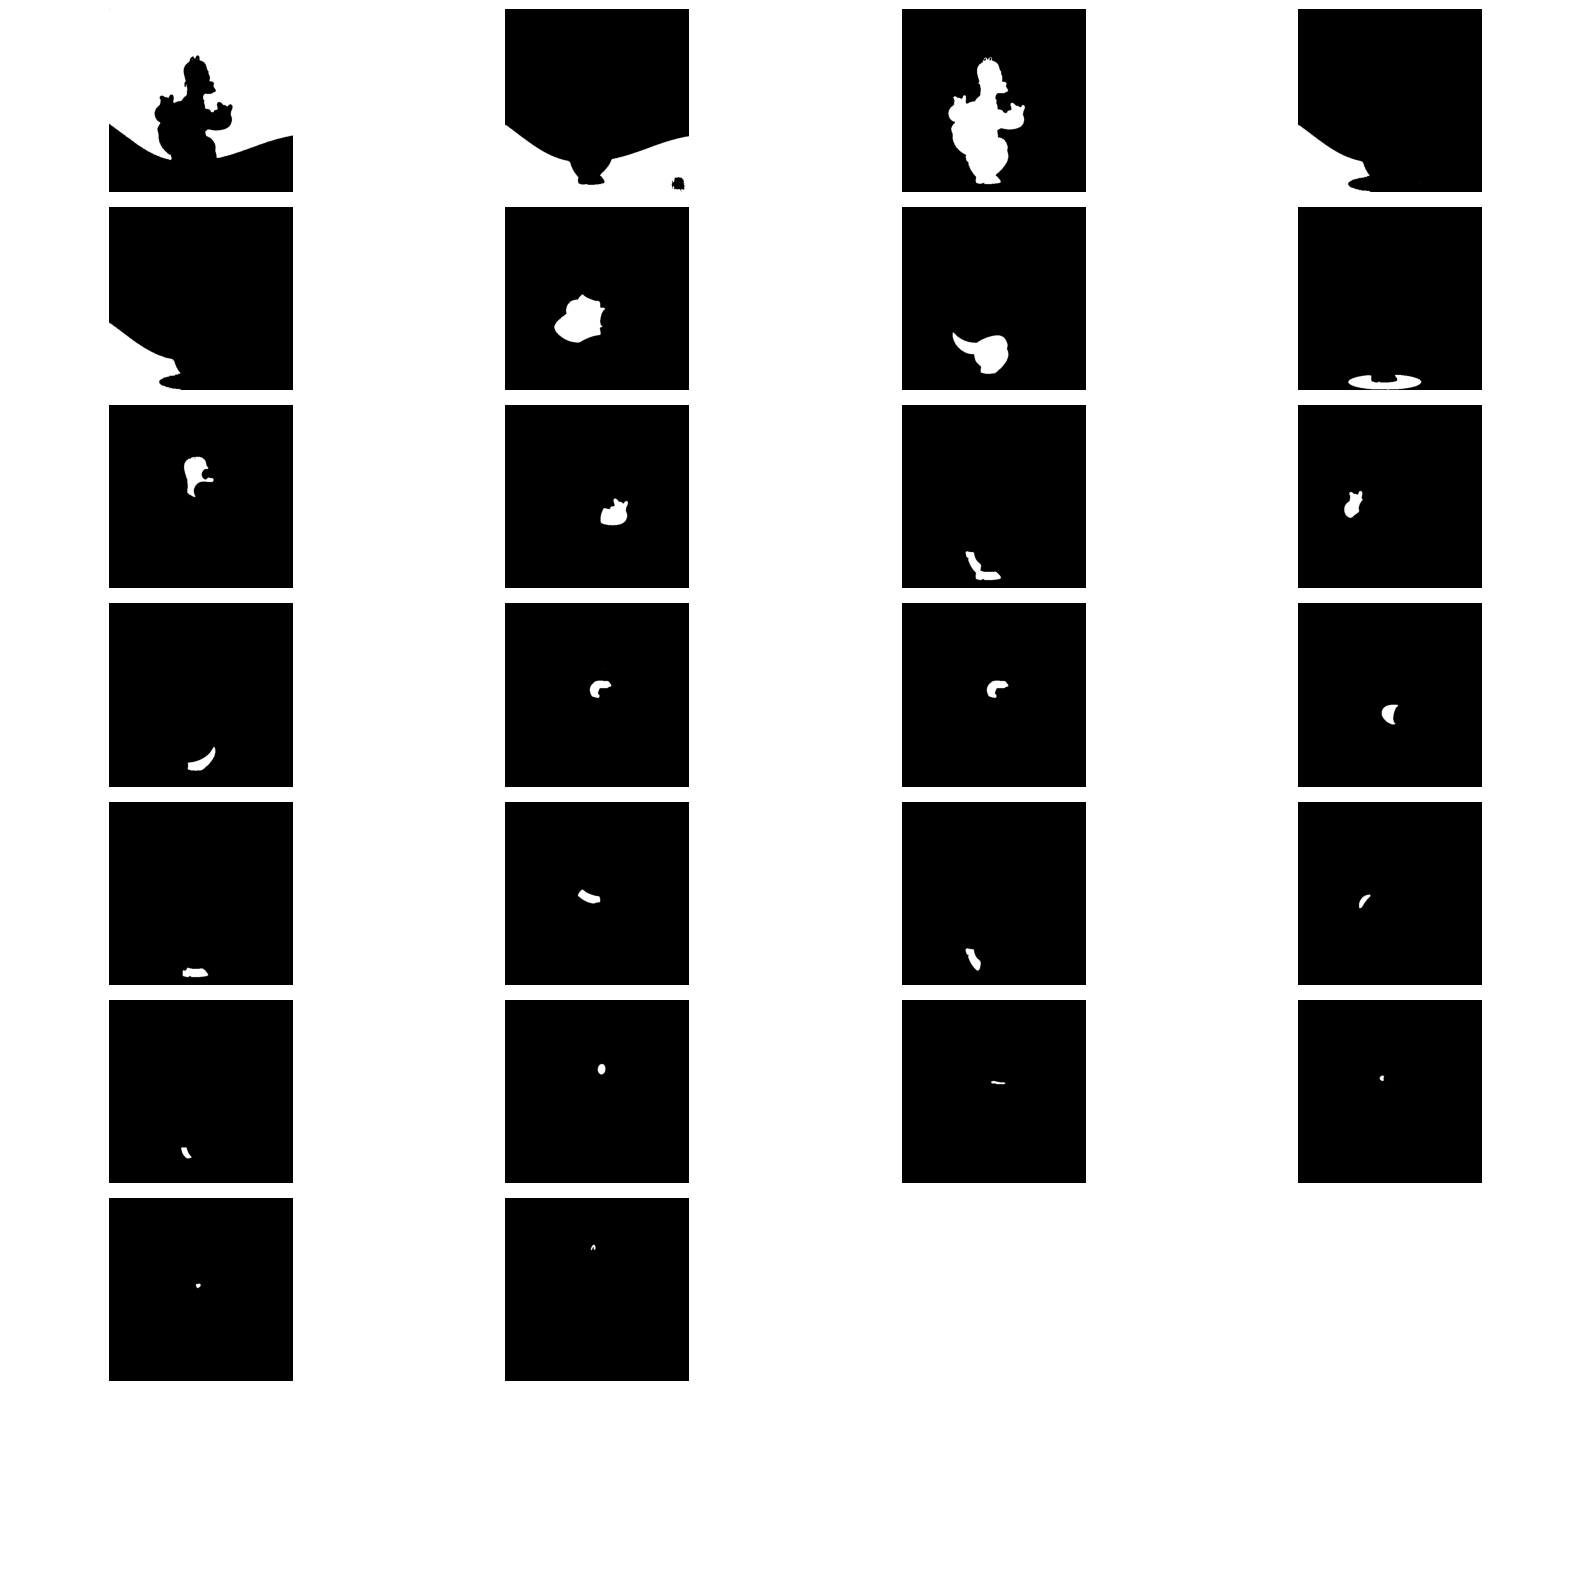

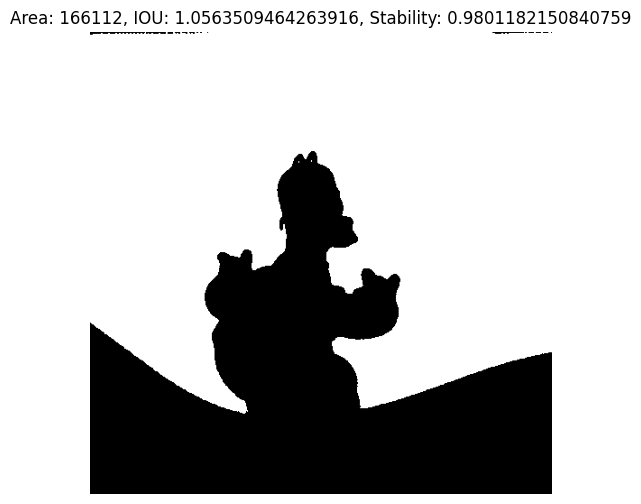

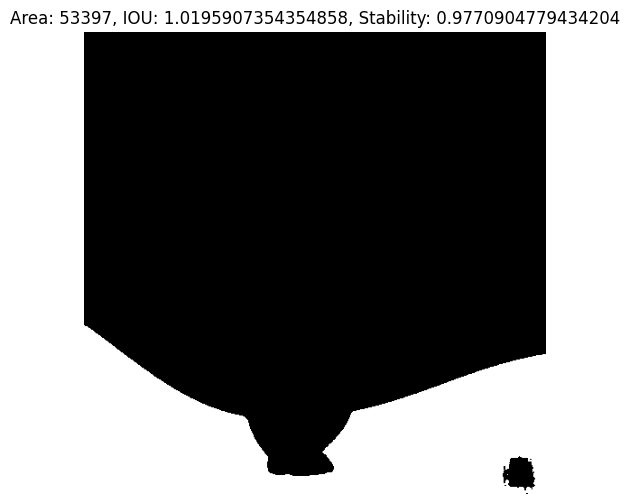

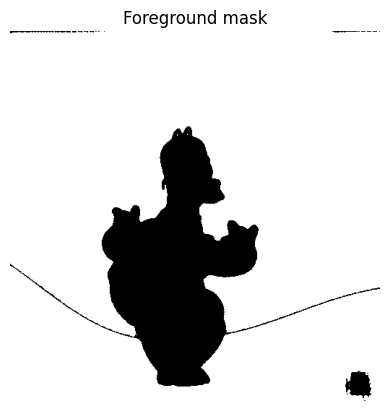

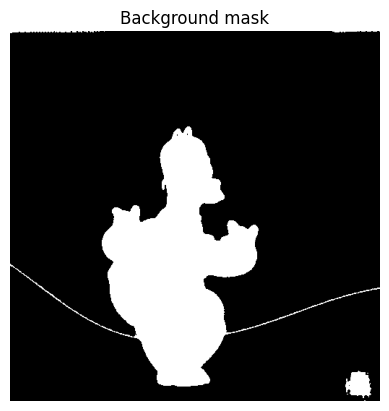

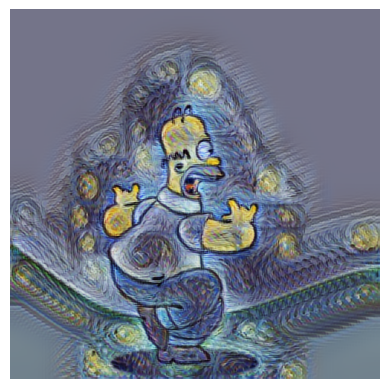

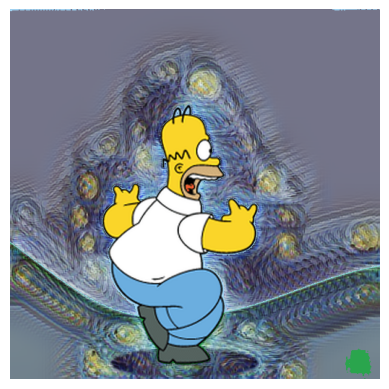

24
Saved grid to masks_grid.png


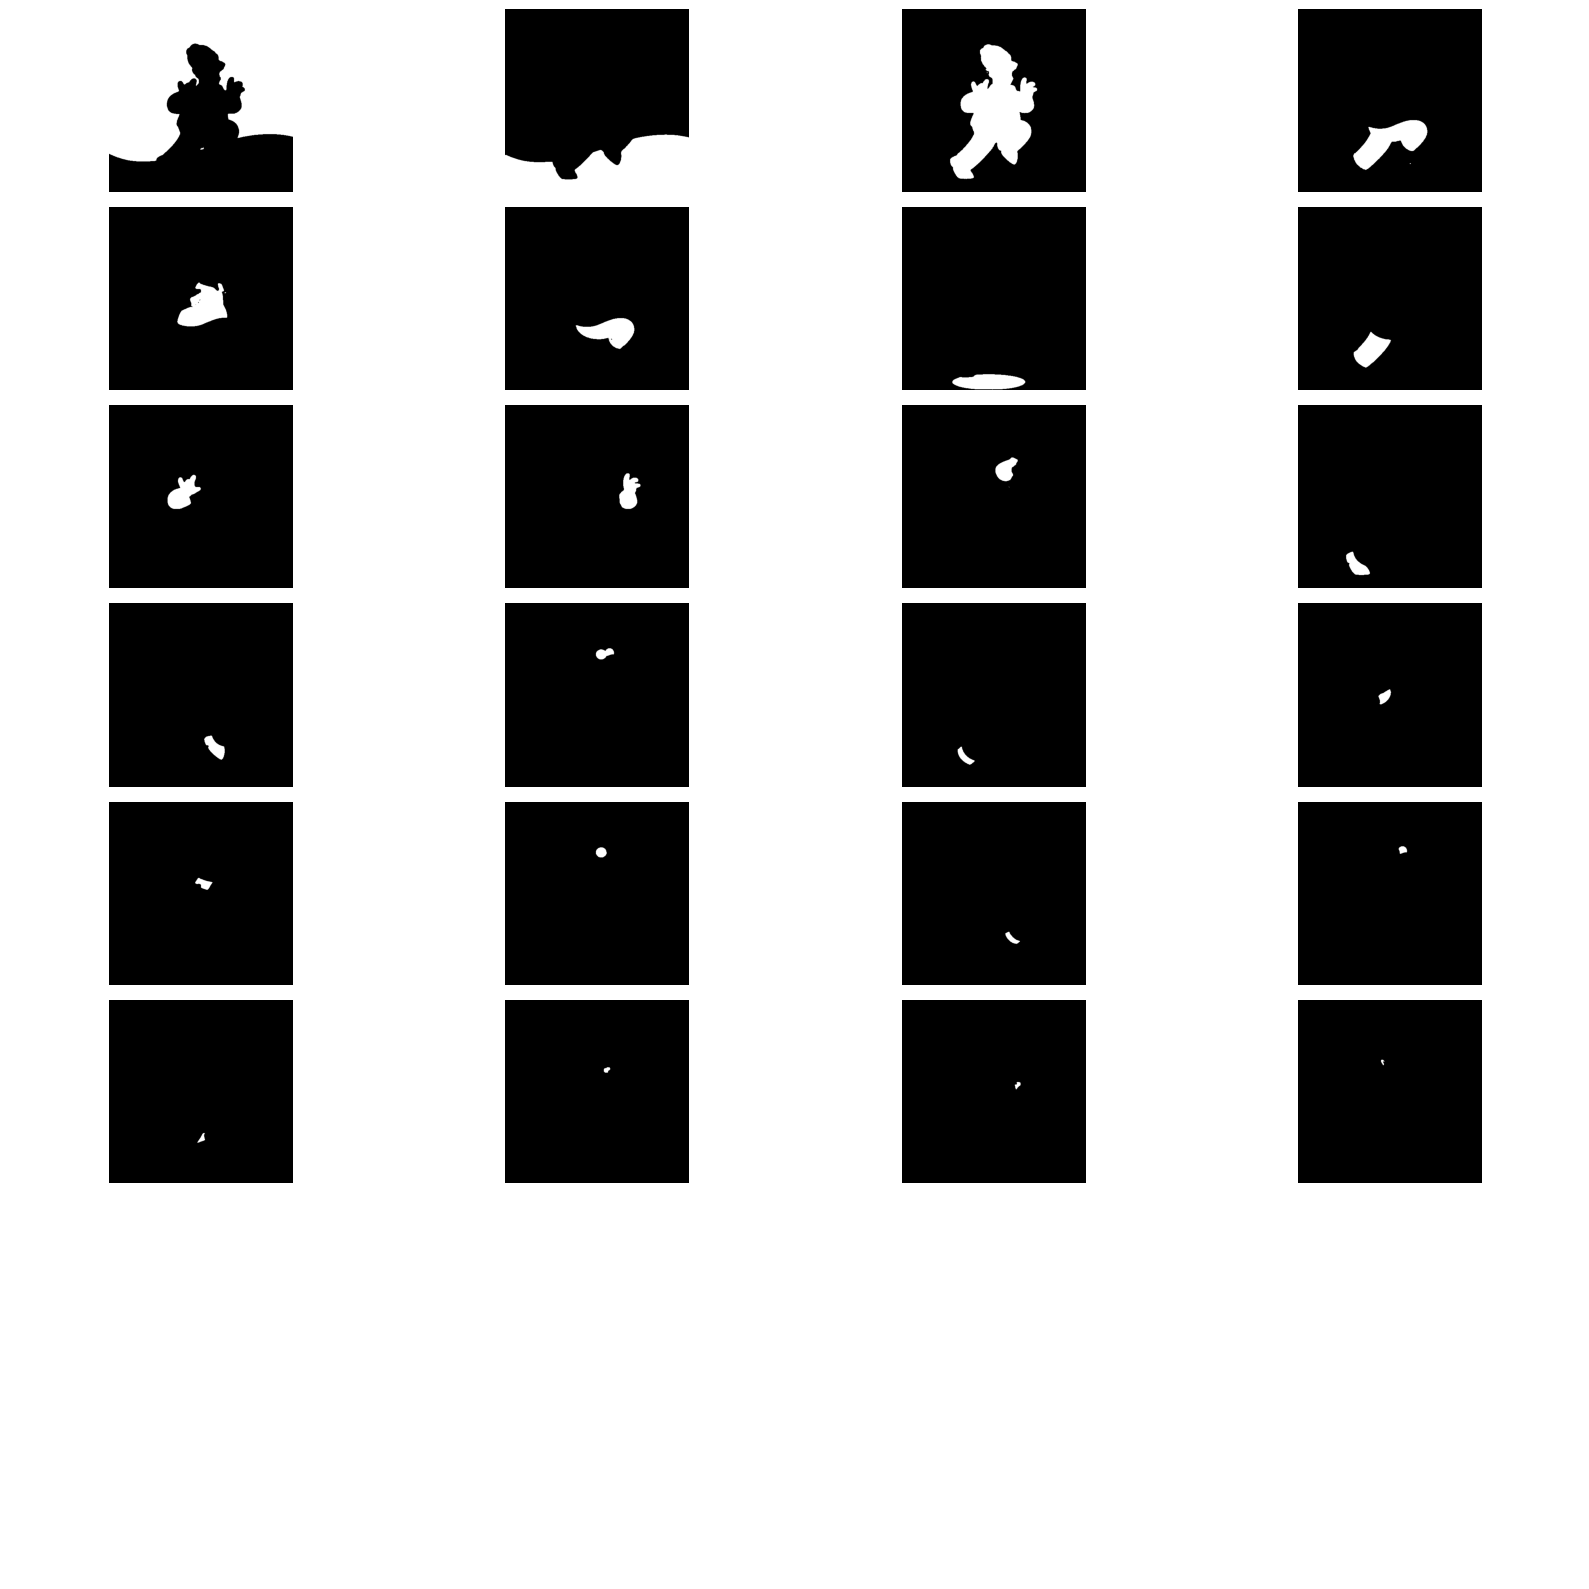

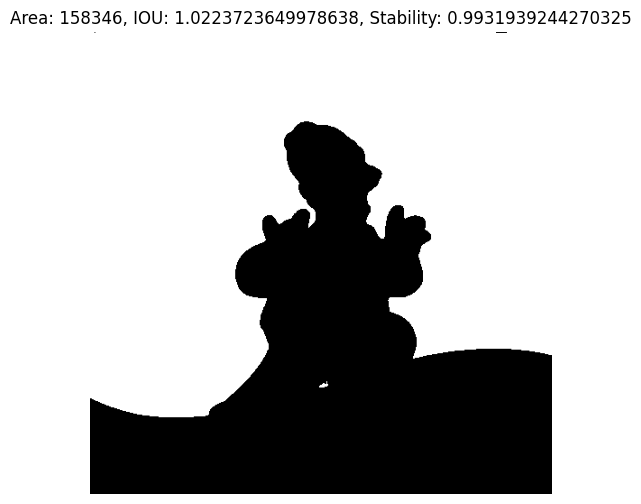

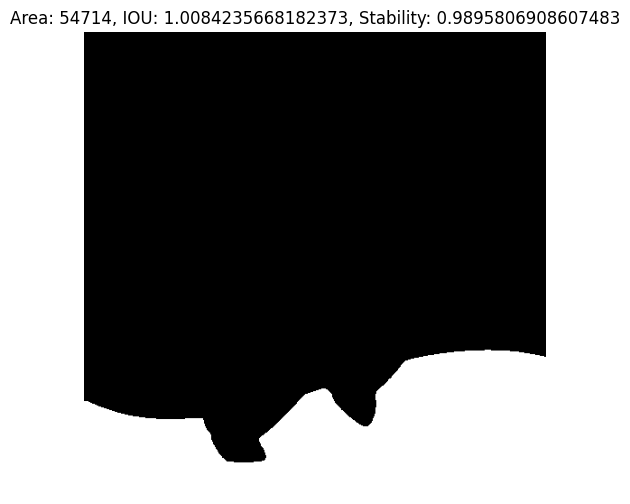

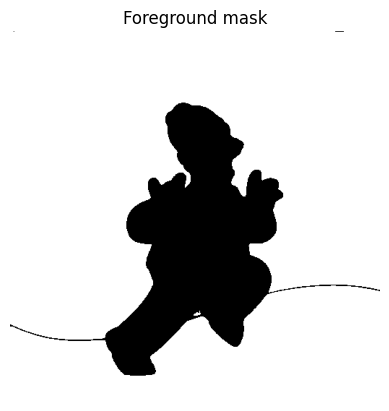

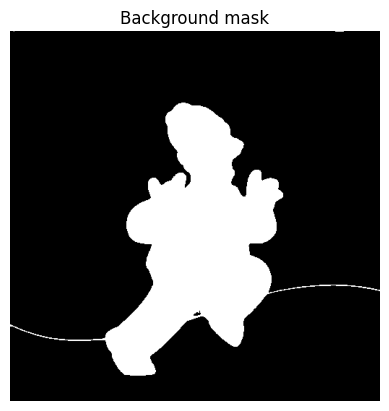

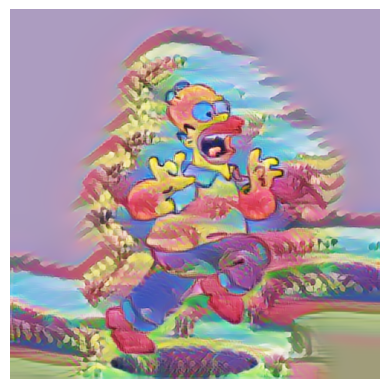

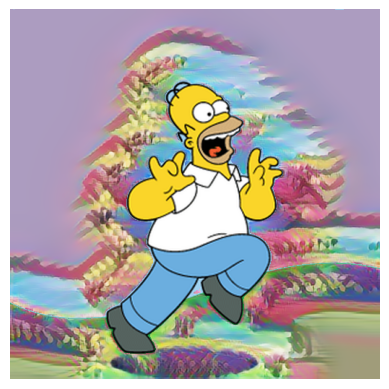

22
Saved grid to masks_grid.png


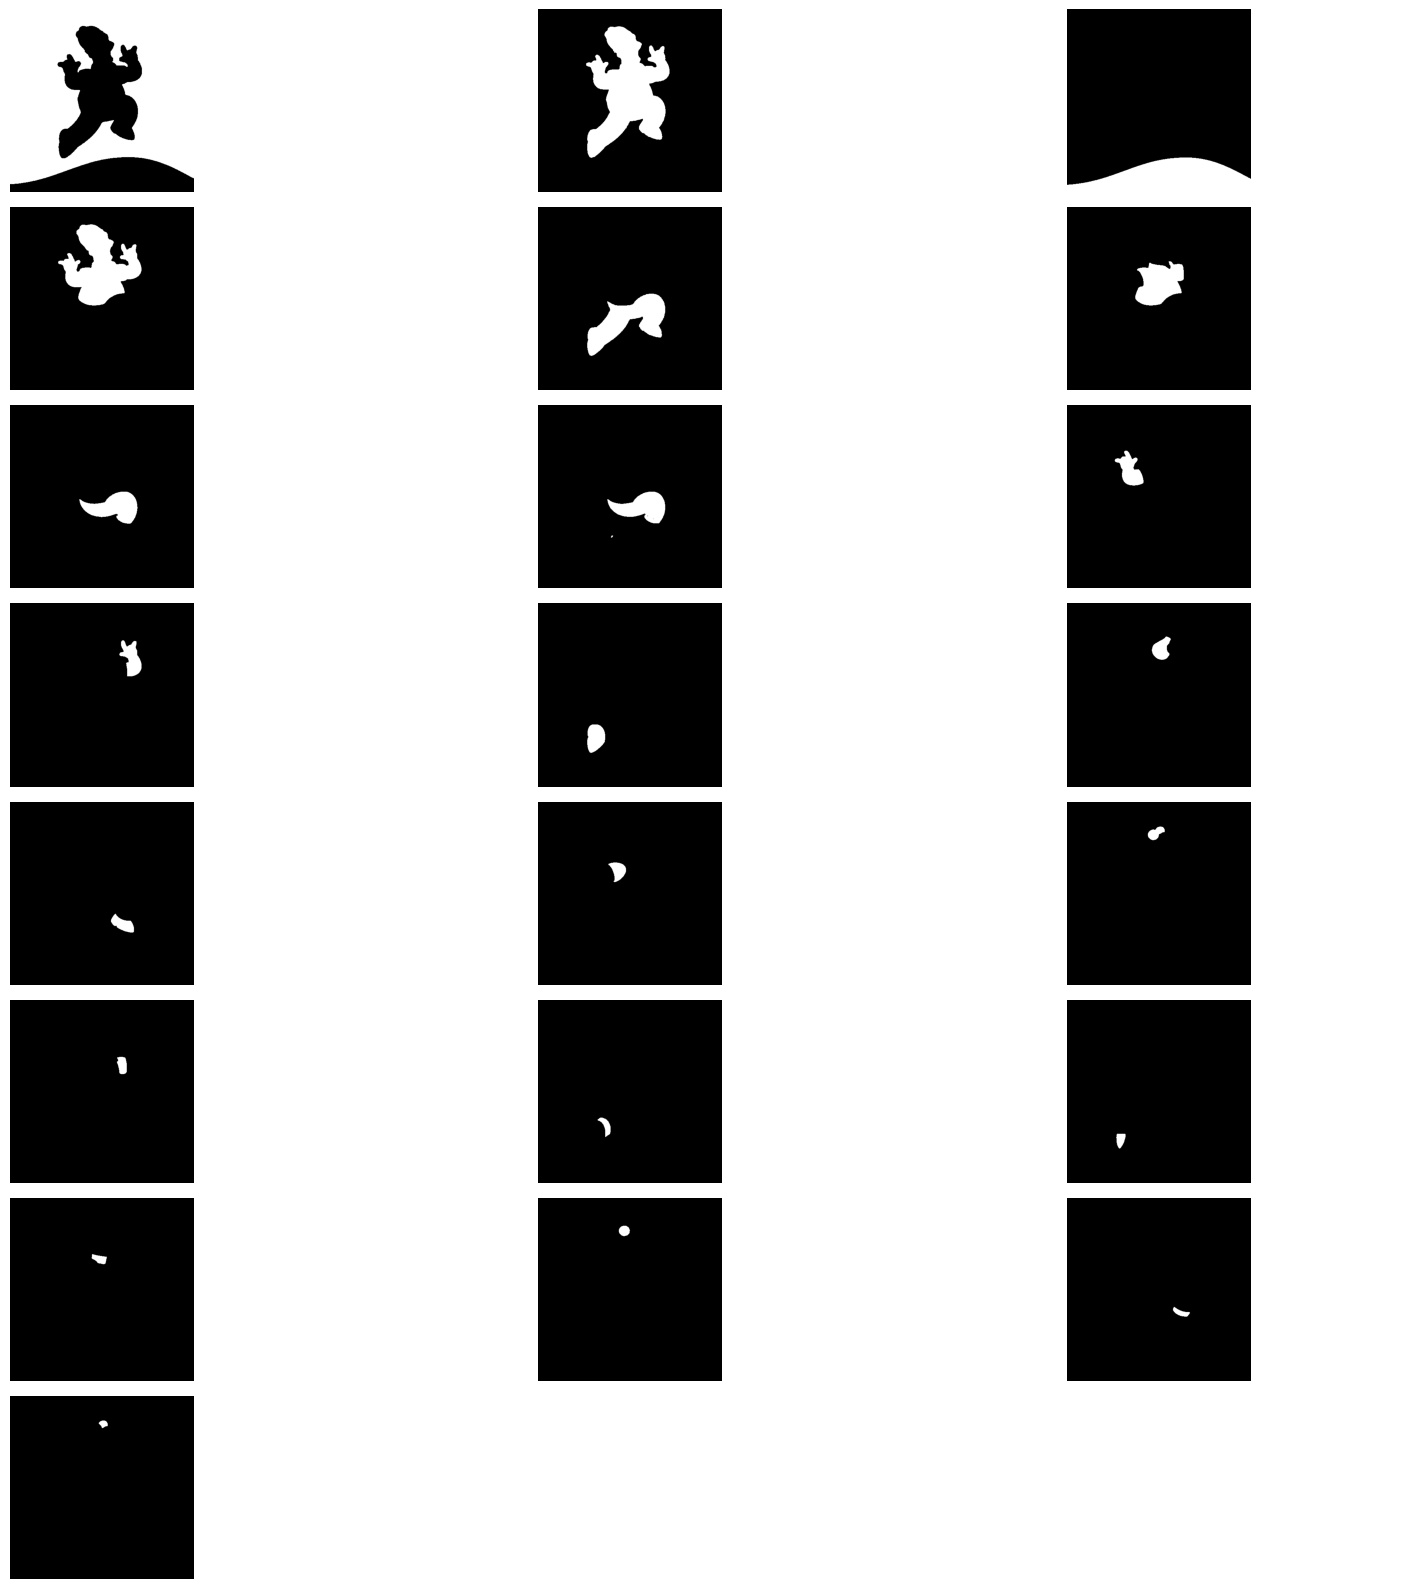

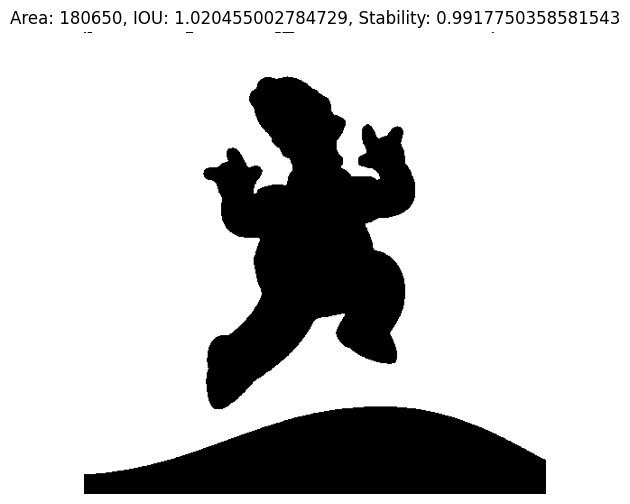

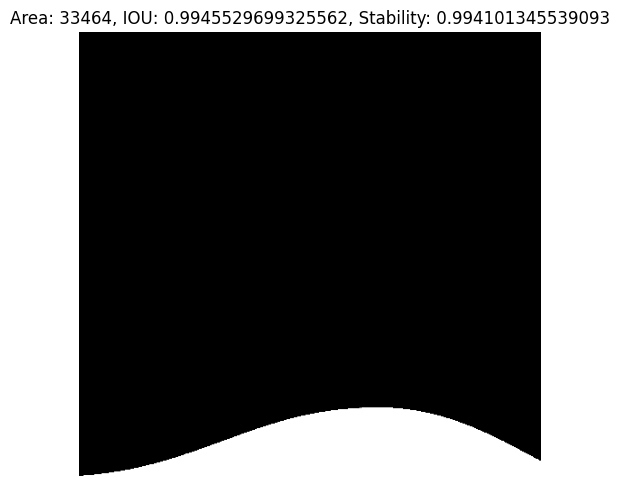

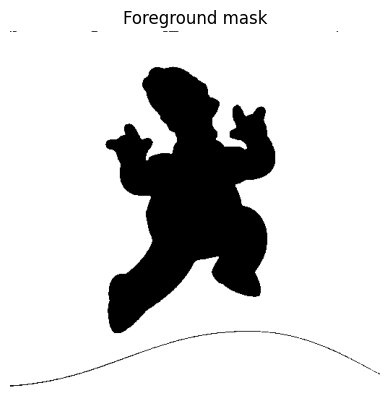

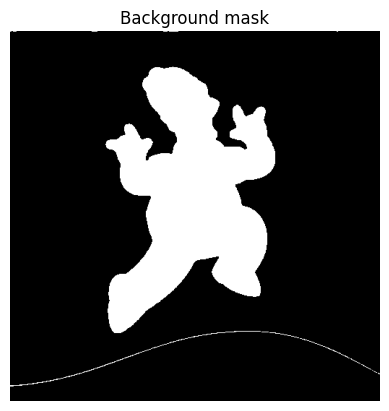

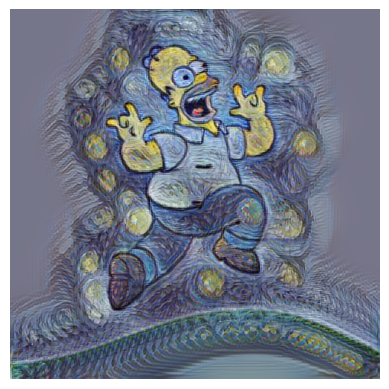

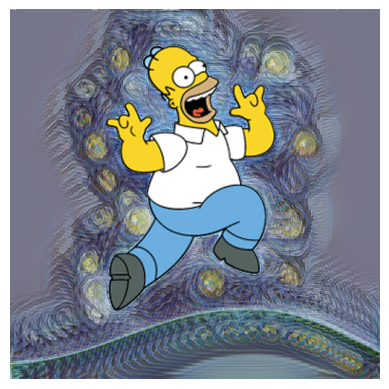

21
Saved grid to masks_grid.png


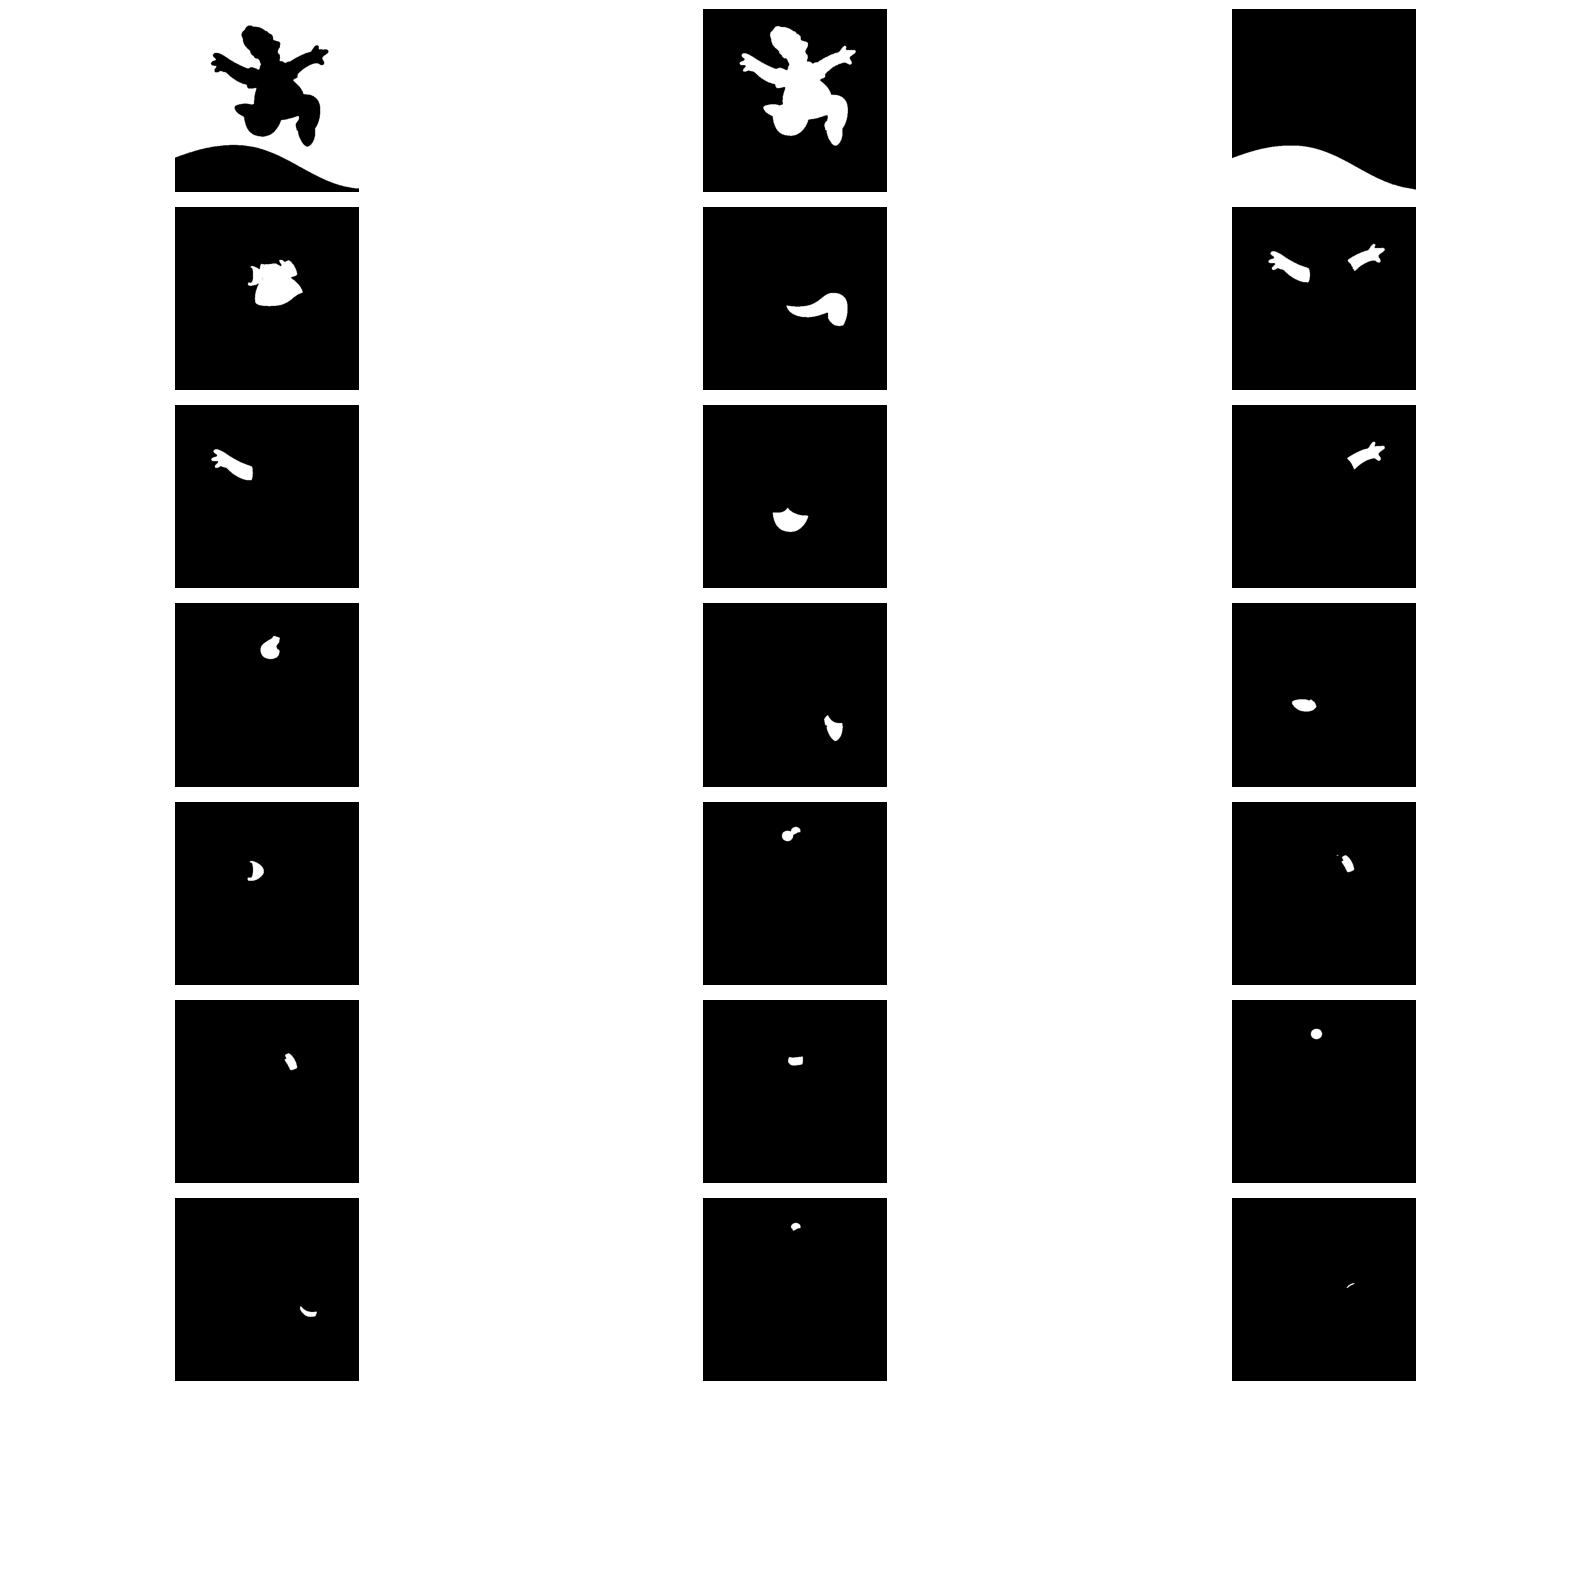

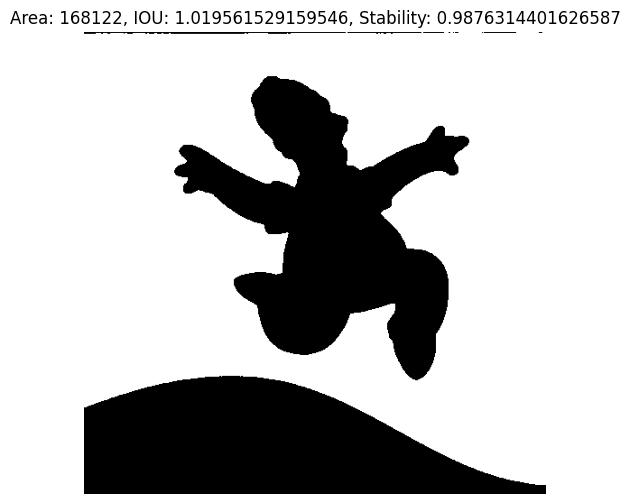

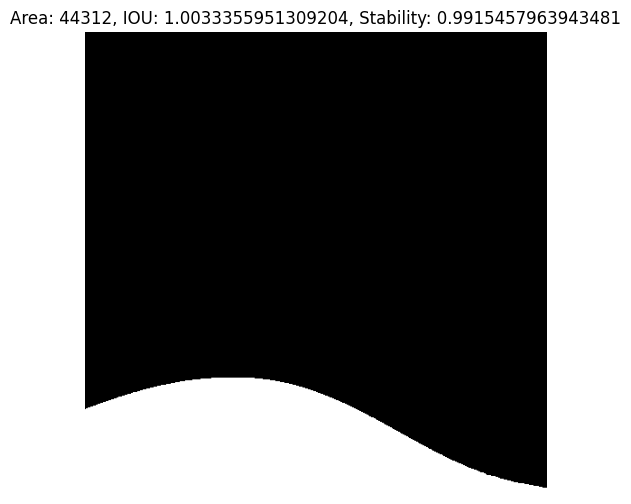

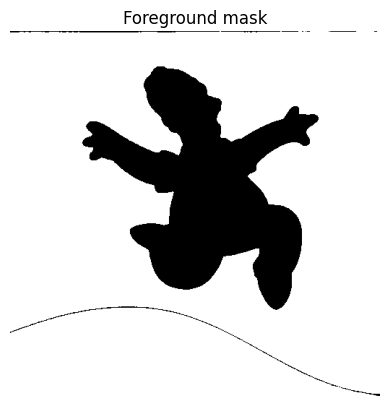

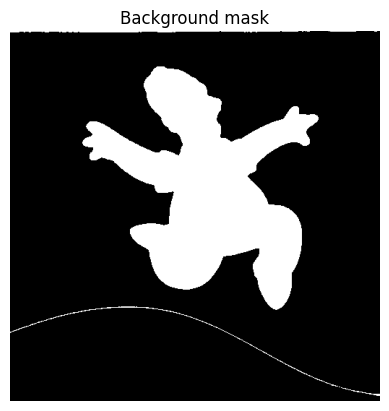

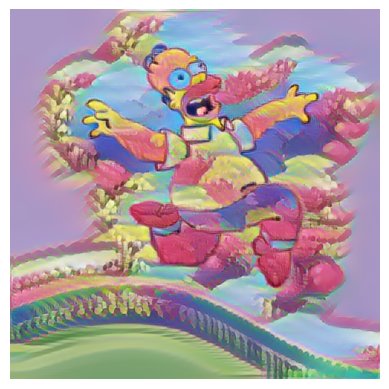

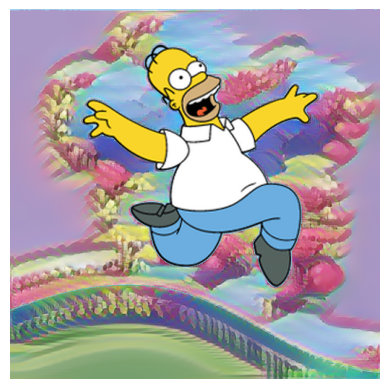

In [204]:
for i in range(1,11):
    img, foreground_mask, background_mask = get_mask(f"gif_data/gif_frames/frame_{i}.png")
    
    plt.imshow(foreground_mask, cmap='gray')
    plt.title('Foreground mask')
    plt.axis('off')
    plt.show()

    plt.imshow(background_mask, cmap='gray')
    plt.title('Background mask')
    plt.axis('off')
    plt.show()

    styled_img, final_img = get_styled_image(img, f"gif_data/styled_images/frame_{i}.png", foreground_mask, background_mask)

    plt.imshow(styled_img)
    plt.axis('off')
    plt.show()
    
    plt.imshow(final_img)
    plt.axis('off')
    plt.show()

    final_pil = PIL.Image.fromarray(final_img.astype(np.uint8))
    final_pil.save(f"gif_data/final_frames_segmented/final_image_{i}.png")
    